#### Summary:
We've run into more object size limits issues when combining the ATAC-seq data... so we're going to try to cut down the matrix rows (windows). Tests of a 50k VariableFeatures() ATAC windows set generated from four high quality samples (R207, R217, R221, R223) went well for 10 and 20 samples. So I'm now trying it on all samples!!!

### Samples to use: R207, R217, R218, R221, R223, R226, R228, R234, R237, R238, R246, R247, R275, R277, R284, R290, R292, R316, R317, R319, R325, R326, R327, R332, R343, R349, R353, R354, R362, R363, R364

Looks like the whole thing ran, but it wiped all the outputs... (adata has all the reductions and assays, the rds file exists)... so I'm just gonna run the plots and hope they're correct. Kinda hard to verify that this didn't error for all samples, but there are 20 in the sample/cluster distribution maps.

In [1]:
#always run this first!!
#essential reticulate functions that allow us to use python packages in R
#you'll need a conda env with 'leidenalg' and 'pandas' installed to do this
#then route reticulate to the python installed in that conda env with the below functions
Sys.setenv(RETICULATE_PYTHON="/home/hmummey/.conda/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/hmummey/.conda/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/hmummey/.conda/envs/reticulate")
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(leidenalg)

In [2]:
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Matrix))
suppressMessages(library(harmony))
suppressMessages(library(data.table))
suppressMessages(library(ggpubr))
suppressMessages(library(future))

# HVWs set 2 - VariableFeatures()
## Read in individually processed data and combine

In [3]:
Sys.time()

[1] "2021-10-13 15:53:29 UTC"

In [ ]:
Sys.time()

In [ ]:
Sys.time()

In [4]:
samples <- c('R207','R217','R218','R221','R223',
             'R226','R228','R234','R237','R238',
             'R246', 'R247', 'R275', 'R277', 'R284', 
             'R290', 'R292', 'R316', 'R317', 'R319',
             'R325','R326','R327','R332','R343',
             'R349','R353','R354','R362','R363','R364')

#make the merged fragment file (update all filepaths and variables!)
system(sprintf('for SAMPLE in %s; do zcat /nfs/lab/projects/multiomic_islet/data/multiomics/cellranger/deep-shallow/$SAMPLE/outs/atac_fragments.tsv.gz | awk -v SAMPLE=$SAMPLE \'BEGIN{FS=OFS="\t"} {print $1,$2,$3,SAMPLE"_"$4,$5}\'; done | sort -k1,1 -k2,2n -S 64G | bgzip -c -@ 16 > /nfs/lab/hmummey/multiomic_islet/intermediates/211010_ATAC_HVW_tests/31samples_merged.atac_fragments.tsv.gz', paste0(samples, collapse=' ')))
system('tabix -p bed /nfs/lab/hmummey/multiomic_islet/intermediates/211010_ATAC_HVW_tests/31samples_merged.atac_fragments.tsv.gz')
outdir <- "/nfs/lab/hmummey/multiomic_islet/intermediates/211010_ATAC_HVW_tests/"
frag.file <- file.path(outdir,'31samples_merged.atac_fragments.tsv.gz')

In [5]:
Sys.time()

[1] "2021-10-13 21:12:42 UTC"

In [6]:
#read in the RDS files
#wipe out the ATAC and SCT componenets
adatas <- list()
for (sample in samples){
    adata <- readRDS(file = sprintf("/nfs/lab/projects/multiomic_islet/outputs/multiome/indv_sample_processing/%s/final_filtered.rds",sample))
    adatas[[sample]] <- adata
    DefaultAssay(adatas[[sample]]) <- "RNA"
    adatas[[sample]][['ATAC']] <- NULL
    adatas[[sample]][['SCT']] <- NULL
}
adatas
#adatas[1]

$R207
An object of class Seurat 
36601 features across 9678 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 3 dimensional reductions calculated: umap.rna, umap.atac, umap.wnn

$R217
An object of class Seurat 
36601 features across 10672 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 3 dimensional reductions calculated: umap.rna, umap.atac, umap.wnn

$R218
An object of class Seurat 
36601 features across 5649 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 3 dimensional reductions calculated: umap.rna, umap.atac, umap.wnn

$R221
An object of class Seurat 
36601 features across 7127 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 3 dimensional reductions calculated: umap.rna, umap.atac, umap.wnn

$R223
An object of class Seurat 
36601 features across 9469 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 3 dimensional reductio

In [7]:
Sys.time()

[1] "2021-10-13 21:47:20 UTC"

In [8]:
# load in and merge RNA -- REPLACE THIS STEP WITH TAKING RNA FROM RDS FILES
# MAKE SURE YOU ADD THE SAMPLE PREFIX TO THESE OR WON'T COMBINE WITH ATAC
adata <- merge(adatas[[samples[[1]]]], y=adatas[samples[2:length(samples)]], add.cell.ids=samples, project='multiomic')
adata$library <- sapply(strsplit(rownames(adata[[]]), '_'), '[[', 1)
adata
adatas <- NULL

An object of class Seurat 
36601 features across 251605 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [9]:
Sys.time()

[1] "2021-10-13 21:52:17 UTC"

In [10]:
adata

An object of class Seurat 
36601 features across 251605 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

### Modified ATAC read in method

In [11]:
#read in ATAC data from the lfm matrices (sm workaround method for now)
# load in starting ATAC long format matrices to a list(CellRanger filtered for now)
atacs <- list()
for (sample in samples) {
    #print(sample)
    wd <- sprintf('/nfs/lab/projects/multiomic_islet/outputs/multiome/indv_sample_processing/%s/', sample)
    atacs[[sample]] <- read.table(file.path(wd, 'atac.long_fmt.filtered_barcode.mtx.gz'), sep='\t', header=FALSE, stringsAsFactors=FALSE)
    atacs[[sample]]$V1 <- as.factor(atacs[[sample]]$V1)
    atacs[[sample]]$V2 <- as.factor(paste0(sample, '_', atacs[[sample]]$V2))
}

In [12]:
Sys.time()

[1] "2021-10-13 23:45:15 UTC"

In [13]:
#read in the HVWs set, we'll cut down all samples to be these windows
hvw_fp2 <- '/nfs/lab/hmummey/multiomic_islet/intermediates/211010_ATAC_HVW_tests/4samples_VariableFeatures_HVWs.txt'
hvws2 <- scan(hvw_fp2, what="", sep="\n")
print(head(hvws2))

#sort alphanumerically
hvws_fin2 <- sort(hvws2)
print(head(hvws_fin2))

[1] "chr17-2050000-2055000"    "chr2-218960000-218965000"
[3] "chr2-181680000-181685000" "chr16-705000-710000"     
[5] "chr7-101165000-101170000" "chr16-70700000-70705000" 
[1] "chr1-10050000-10055000"   "chr1-10055000-10060000"  
[3] "chr1-10070000-10075000"   "chr1-10075000-10080000"  
[5] "chr1-100790000-100795000" "chr1-10125000-10130000"  


In [14]:
Sys.time()

[1] "2021-10-13 23:45:15 UTC"

In [15]:
#function which takes in a list of long format atac_fragment dfs with 
#sample names (df), an overall windows file (windows) and then makes these 
#into sparse matrices and merges them together

#modified to take in the hvws set and use those... will still check if 
#there's any missing windows and add those, so only a few changes!

merge_sparse_matrices_hvws <- function(dfs, windows){
    samples <- names(dfs)
    for (sample in samples){
        #get missing windows list for this sample
        print(paste(sample,Sys.time(),sep=': '))
        df <- dfs[[sample]]
        mis_windows <- windows[!windows %in% levels(df$V1)]
        
        #make sure there are missing_windows
        if (length(mis_windows) > 0){
            print('Adding missing windows')
            #create a new long format matrix (sm) with the missing windows added as 0 counts
            filler_bc <- as.character(df$V2[[1]])
            print(paste("Using filler BC:",filler_bc,sep=" "))
            new_rows <- cbind(as.data.frame(mis_windows),
                              as.data.frame(rep(filler_bc),length(mis_windows)),
                              as.data.frame(rep(0,length(mis_windows))))
            colnames(new_rows) <- c("V1","V2","V3")
            lfm <- rbind(df,new_rows)
        #if there aren't, set lfm to df
        } else {
            print('No windows were missing')
            lfm <- df
        }
        
        #cut down lfm to just be the hvws (windows)
        lfm_cut <- lfm[lfm$V1 %in% windows,]
        
        #set the levels of the lfm based on the desired bc order and reorder V1
        lfm_cut$V1 <- factor(lfm_cut$V1, levels=windows)
        lfm2 <- lfm_cut[order(lfm_cut$V1),]
        lfm2$V2 <- as.factor(lfm2$V2)
        
        if (sample == samples[1]){
            #if first sample, will make the overall sparse matrix 
            overall_sm <- with(lfm2,sparseMatrix(i=as.numeric(V1), j=as.numeric(V2), x=V3, dimnames=list(levels(V1), levels(V2))))
            print(dim(overall_sm))
            
        } else {
            #otherwise, convert into a sparse matrix and add to the overall one
            sm = with(lfm2,sparseMatrix(i=as.numeric(V1), j=as.numeric(V2), x=V3, dimnames=list(levels(V1), levels(V2))))
            print(dim(sm))
            overall_sm = cbind(overall_sm, sm) 
        }
    }
    return(overall_sm)
}

In [16]:
overall_sm2 <- merge_sparse_matrices_hvws(atacs,hvws_fin2)
dim(overall_sm2)
head(overall_sm2)

[1] "R207: 2021-10-13 23:45:15"
[1] "Adding missing windows"
[1] "Using filler BC: R207_AAACAGCCATTGTGTG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  9678
[1] "R217: 2021-10-13 23:46:08"
[1] "Adding missing windows"
[1] "Using filler BC: R217_AAAGCACCATTAAAGG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 10672
[1] "R218: 2021-10-13 23:46:56"
[1] "Adding missing windows"
[1] "Using filler BC: R218_AAACCGGCAGTACCGT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  5649
[1] "R221: 2021-10-13 23:47:30"
[1] "Adding missing windows"
[1] "Using filler BC: R221_AAAGCTTGTTAGTGAT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7127
[1] "R223: 2021-10-13 23:47:58"
[1] "Adding missing windows"
[1] "Using filler BC: R223_AAACGCGCAGCATTAT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  9469
[1] "R226: 2021-10-13 23:48:42"
[1] "Adding missing windows"
[1] "Using filler BC: R226_AAACGTACATATAACC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7842
[1] "R228: 2021-10-13 23:49:25"
[1] "Adding missing windows"
[1] "Using filler BC: R228_AAACGGATCATGTTTC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7475
[1] "R234: 2021-10-13 23:50:02"
[1] "Adding missing windows"
[1] "Using filler BC: R234_AAACCGAAGCCATCAG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  8505
[1] "R237: 2021-10-13 23:50:41"
[1] "Adding missing windows"
[1] "Using filler BC: R237_AAACCGCGTACAAAGA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7857
[1] "R238: 2021-10-13 23:51:32"
[1] "Adding missing windows"
[1] "Using filler BC: R238_AAACCAACAGCATGTC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7817
[1] "R246: 2021-10-13 23:52:08"
[1] "Adding missing windows"
[1] "Using filler BC: R246_AAGACAAGTATTCGTC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  2221
[1] "R247: 2021-10-13 23:52:25"
[1] "Adding missing windows"
[1] "Using filler BC: R247_AAAGCTTGTTAATGCG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7293
[1] "R275: 2021-10-13 23:53:09"
[1] "Adding missing windows"
[1] "Using filler BC: R275_AAACAGCCATTGTCAG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  6166
[1] "R277: 2021-10-13 23:53:37"
[1] "Adding missing windows"
[1] "Using filler BC: R277_AACATAGCACCTGGTG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  8029
[1] "R284: 2021-10-13 23:54:08"
[1] "Adding missing windows"
[1] "Using filler BC: R284_AACCTTAAGTGAACAG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7417
[1] "R290: 2021-10-13 23:54:57"
[1] "Adding missing windows"
[1] "Using filler BC: R290_AAATCCGGTCCTCCAA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  9380
[1] "R292: 2021-10-13 23:55:45"
[1] "Adding missing windows"
[1] "Using filler BC: R292_AAACATGCATGAATCT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  8103
[1] "R316: 2021-10-13 23:56:40"
[1] "Adding missing windows"
[1] "Using filler BC: R316_AAACAGCCATGAATAG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 13171
[1] "R317: 2021-10-13 23:58:03"
[1] "Adding missing windows"
[1] "Using filler BC: R317_AAAGCCGCACAAACTT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 12520
[1] "R319: 2021-10-13 23:59:07"
[1] "Adding missing windows"
[1] "Using filler BC: R319_AAACGGATCCCTGGAA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 11438
[1] "R325: 2021-10-14 00:00:19"
[1] "Adding missing windows"
[1] "Using filler BC: R325_AATCCATCACTAAGCC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  2164
[1] "R326: 2021-10-14 00:00:38"
[1] "Adding missing windows"
[1] "Using filler BC: R326_AAATGCCTCTTGTCCA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 12198
[1] "R327: 2021-10-14 00:01:58"
[1] "Adding missing windows"
[1] "Using filler BC: R327_AAATGGCCAGTCTAGC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7811
[1] "R332: 2021-10-14 00:02:52"
[1] "Adding missing windows"
[1] "Using filler BC: R332_AAACCGAAGCTGCACA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 10156
[1] "R343: 2021-10-14 00:04:00"
[1] "Adding missing windows"
[1] "Using filler BC: R343_AACAGATAGCGGGCAA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  5808
[1] "R349: 2021-10-14 00:04:39"
[1] "Adding missing windows"
[1] "Using filler BC: R349_AACAGCAAGAGGCTAA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  6113
[1] "R353: 2021-10-14 00:05:19"
[1] "Adding missing windows"
[1] "Using filler BC: R353_AAAGCCCGTAATCGCA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  8720
[1] "R363: 2021-10-14 00:08:17"
[1] "Adding missing windows"
[1] "Using filler BC: R363_AAACCGCGTTAGGCTA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 10646
[1] "R364: 2021-10-14 00:09:27"
[1] "Adding missing windows"
[1] "Using filler BC: R364_AAATCCGGTACCAGGT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  5353


[1]  50000 251605

   [[ suppressing 34 column names 'R207_AAACAGCCAAACGGGC-1', 'R207_AAACAGCCACAAAGAC-1', 'R207_AAACAGCCAGCAAGTG-1' ... ]]



6 x 251605 sparse Matrix of class "dgCMatrix"
                                                                              
chr1-10050000-10055000   2 . . . . . . . . . . . 2 . . . . . . . . . . . . . .
chr1-10055000-10060000   2 2 . . . . . . 2 . . . 2 . . . . . . . . 2 . . . . .
chr1-10070000-10075000   . . . . . . . . . . . . . . . . 2 . . 2 . . . 4 . . .
chr1-10075000-10080000   . . . . . . . . . . . . . . . . 2 . . . . . . 4 . . .
chr1-100790000-100795000 1 . . . . . 1 . . . . . 2 . . . . . . 2 . . . . . . .
chr1-10125000-10130000   . . . . . . . 2 . 1 . . . . . . . . . . . . . . . . .
                                             
chr1-10050000-10055000   . . . . . . . ......
chr1-10055000-10060000   . . 2 . . . . ......
chr1-10070000-10075000   . . . . . . . ......
chr1-10075000-10080000   . . . . . . . ......
chr1-100790000-100795000 . 2 . . . . . ......
chr1-10125000-10130000   . . . . . . . ......

 .....suppressing 251571 columns in show(); maybe adjust 'options(max.print= *

In [17]:
#check if the windows of overall_sm are sorted (they should be)
sorted_windows2 <- sort(row.names(overall_sm2))
table(sorted_windows2 == row.names(overall_sm2))


 TRUE 
50000 

In [18]:
Sys.time()

[1] "2021-10-14 00:10:10 UTC"

In [19]:
#continue to make Seurat compatible object
atac <- overall_sm2
suppressMessages(annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86))
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

#make sure this is the correct merged fragment file!!
#frag.file <- '/nfs/lab/hmummey/multiomic_islet/intermediates/211010_ATAC_HVW_tests/10samples_merged.atac_fragments.tsv.gz'
atac_assay <- CreateChromatinAssay(counts=atac, sep=c('-', '-'), genome='hg38', fragments=frag.file, min.cells=10, min.features=-1, annotation=annotations)

Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objec

In [20]:
suppressMessages(adata[['ATAC']] <- atac_assay)
#atacs <- atac <- NULL
gc()

used        (Mb)    gc trigger  (Mb)     max used    (Mb)    
Ncells    12981029   693.3    24077121   1285.9    24077121   1285.9
Vcells 10784178389 82276.8 16929649958 129163.0 16927236741 129144.6

In [21]:
Sys.time()

[1] "2021-10-14 01:04:56 UTC"

In [22]:
adata
adata[["ATAC"]]

An object of class Seurat 
86601 features across 251605 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: ATAC

ChromatinAssay data with 50000 features for 251605 cells
Variable features: 0 
Genome: hg38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

## Perform analyses and clustering

In [23]:
# add qc metrics from 10x
qcs <- list()
for (sample in samples) {
    wd <- sprintf('/nfs/lab/projects/multiomic_islet/data/multiomics/cellranger/deep-shallow/%s/outs/', sample)
    qc <- read.table(file.path(wd, 'per_barcode_metrics.csv'), sep=',', header=TRUE, stringsAsFactors=1)
    qc <- qc[qc$is_cell==1,]
    qc$gex_barcode <- paste0(sample, '_', qc$gex_barcode)
    qcs[[sample]] <- qc
}
qc <- as.data.frame(rbindlist(qcs))
rownames(qc) <- qc$gex_barcode
qc <- qc[Cells(adata), 6:length(colnames(qc))]
adata <- AddMetaData(adata, qc)
qc <- qcs <- NULL
gc()

used        (Mb)    gc trigger  (Mb)     max used    (Mb)    
Ncells    13007841   694.7    24077121   1285.9    24077121   1285.9
Vcells 10784245998 82277.3 16929649958 129163.0 16927236741 129144.6

In [ ]:
# RNA analysis
DefaultAssay(adata) <- 'RNA'
suppressWarnings(adata <- SCTransform(adata, verbose=FALSE))
adata <- RunPCA(adata)
adata <- RunHarmony(adata, group.by.vars='library', assay.use='SCT', reduction.save='harmony.rna')
adata <- RunUMAP(adata, dims=1:50, reduction='harmony.rna', reduction.name='umap.rna', reduction.key='rnaUMAP_')
#adata <- RunUMAP(dims=1:50, reduction.name='umap.rna', reduction.key='rnaUMAP_')

# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(adata) <- 'ATAC'
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0', verbose=FALSE)
adata <- RunSVD(adata)
hm_atac <- HarmonyMatrix(Embeddings(adata, reduction='lsi'), adata$library, do_pca=FALSE)
adata[['harmony.atac']] <- CreateDimReducObject(embeddings=hm_atac, key='atac_', assay='ATAC')
adata <- RunUMAP(adata, dims=2:50, reduction='harmony.atac', reduction.name='umap.atac', reduction.key='atacUMAP_')
#adata <- RunUMAP(adata, dims=2:50, reduction='lsi', reduction.name='umap.atac', reduction.key='atacUMAP_')

PC_ 1 
Positive:  GP2, NEAT1, PRSS2, CPA1, CELA3A, CD44, REG1A, CTRB2, CEL, PRSS1 
	   PNLIPRP1, MECOM, CTRB1, CUZD1, CPB1, CPA2, SPINK1, CHRM3, CLPS, NIBAN1 
	   CELA3B, REG1B, TC2N, AKAP13, RAB27B, CA12, PNLIP, RBPJL, ZFP36L1, SH3RF2 
Negative:  INS, ZNF385D, SST, PAM, TRPM3, RIMS2, PDE4D, RFX3, MAGI2, GPC6 
	   KCNMB2, ENPP2, NRXN1, CADM1, GCG, LINC01099, NRG1, DPP6, SNTG1, RGS7 
	   DGKB, SYT16, NOL4, SPAG16, CNTN5, NBEA, LSAMP, SEC24D, KCNB2, FGF14 
PC_ 2 
Positive:  MT-CO3, MT-CO2, MT-ATP6, MT-ND3, MT-CO1, PKHD1, CFTR, MT-CYB, SLC4A4, MT-ND4 
	   MT-ND1, BICC1, MT-ND2, BARX2, THSD4, ADAMTS9, MACC1, ADAMTS9-AS2, MT-ND5, MYOF 
	   CD44, NCEH1, ZEB2, ABTB2, RUNX1, TFPI2, CXCL8, PMEPA1, TJP2, TGFA 
Negative:  GP2, PRSS2, CPA1, CELA3A, PNLIPRP1, CEL, CTRB2, REG1A, PRSS1, CPB1 
	   CUZD1, CPA2, CTRB1, MECOM, CLPS, CELA3B, SPINK1, ZNF385D, CHRM3, REG1B 
	   PNLIP, RBPJL, PLA2G1B, CA12, PAM, TRHDE, HSPH1, PDK4, IFRD1, CTRC 
PC_ 3 
Positive:  MT-CO3, MT-CO2, MT-ND3, MT-ATP6, INS, MT-CO1, 

In [ ]:
adata

In [ ]:
Sys.time()

In [ ]:
# Combining Modalities
#adata <- FindMultiModalNeighbors(adata, reduction.list=list('pca', 'lsi'), dims.list=list(1:50, 2:50))
adata <- FindMultiModalNeighbors(adata, reduction.list=list('harmony.rna', 'harmony.atac'), dims.list=list(1:50, 2:50))
adata <- RunUMAP(adata, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
#mem_change(adata <- FindClusters(adata, graph.name='wsnn', algorithm=4,  resolution = 0.5, verbose=FALSE))
adata <- FindClusters(adata, graph.name='wsnn', algorithm=4,  resolution = 0.25, verbose=FALSE, method = 'igraph')

adata$log_nCount_ATAC=log(adata$nCount_ATAC)
adata$log_nCount_SCT=log(adata$nCount_SCT)
adata$log_nFeature_ATAC=log(adata$nFeature_ATAC)
adata$log_nFeature_SCT=log(adata$nFeature_SCT)

In [ ]:
Sys.time()

In [54]:
adata

An object of class Seurat 
120106 features across 251605 samples within 3 assays 
Active assay: ATAC (50000 features, 50000 variable features)
 2 other assays present: RNA, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [ ]:
adata[["ATAC"]]

## Visualize clustering

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
"ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


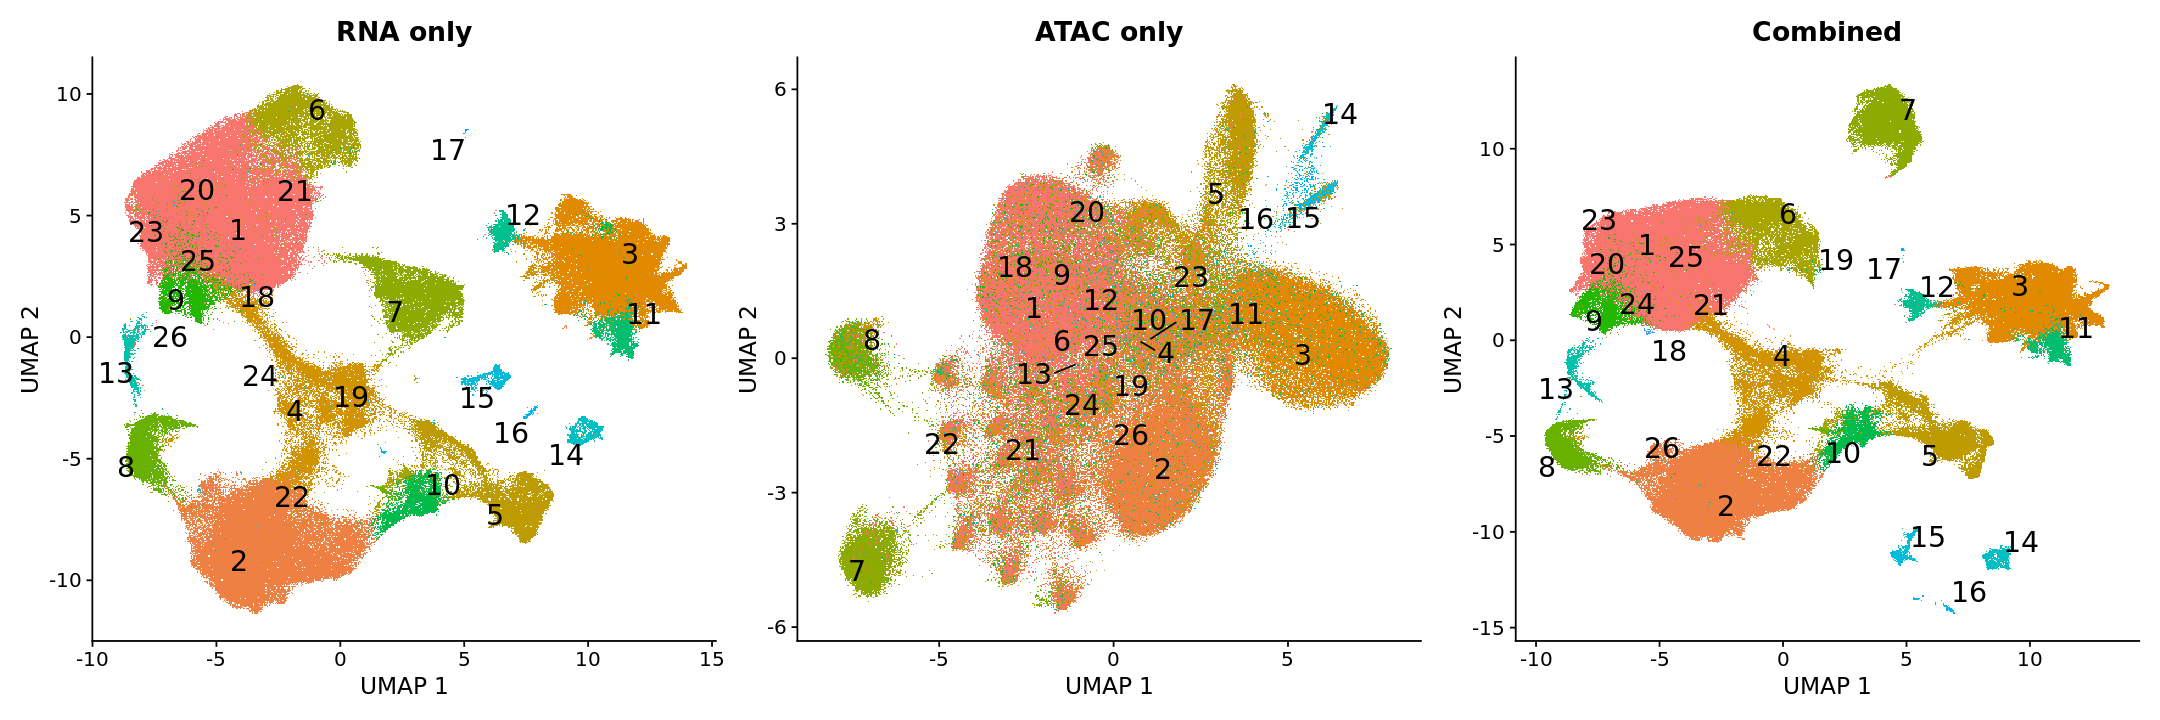

In [39]:
options(repr.plot.width=18, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

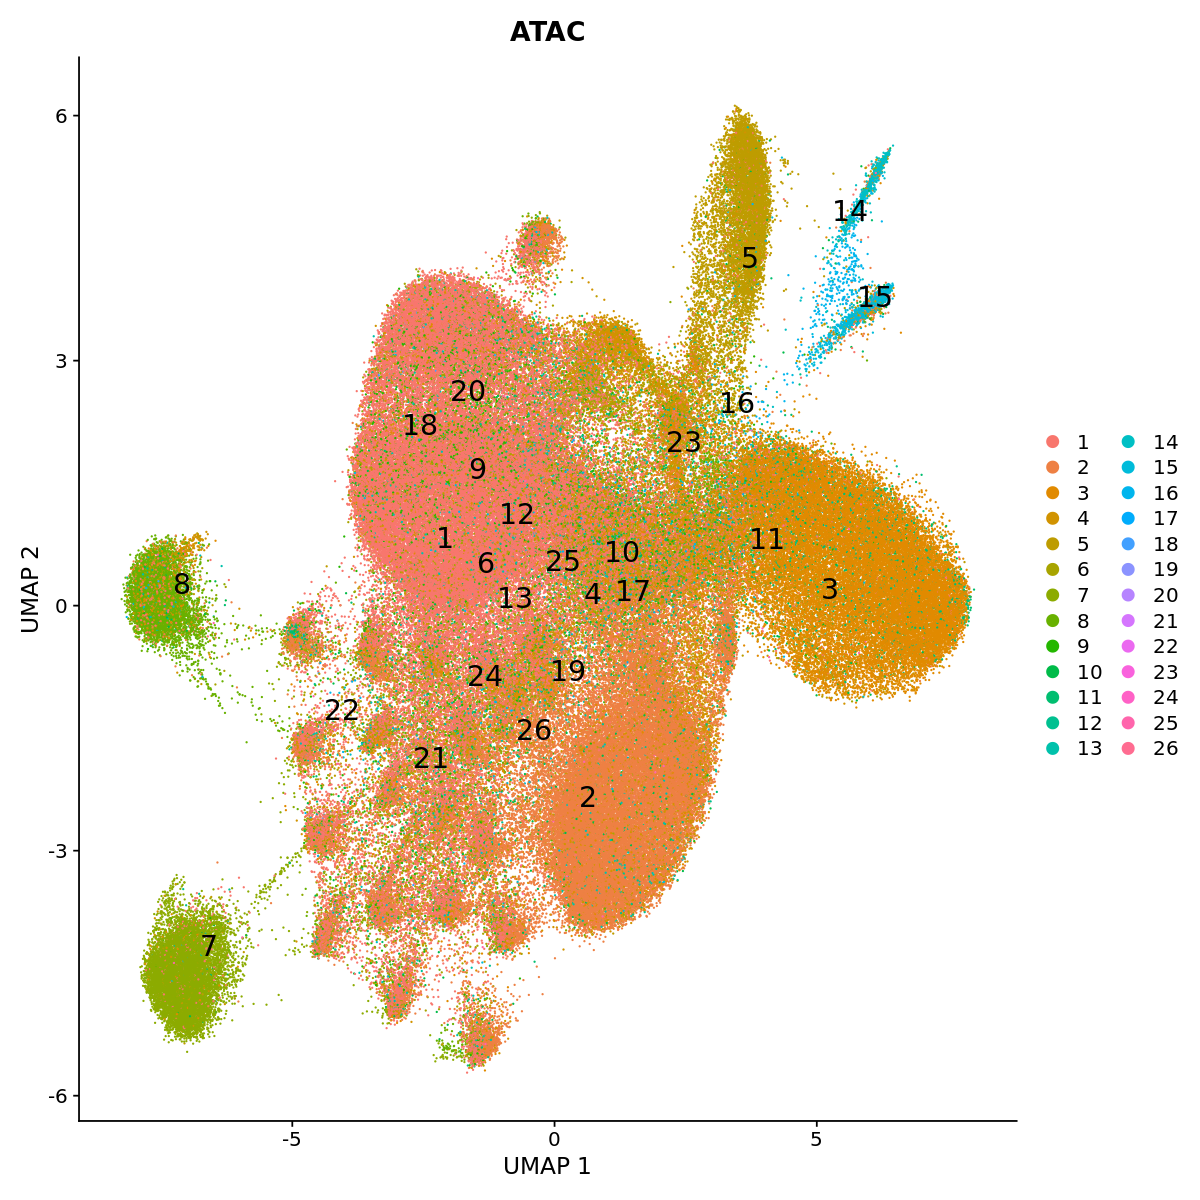

In [159]:
options(repr.plot.width=10, repr.plot.height=10)
p3 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE, raster=FALSE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC')
p3

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



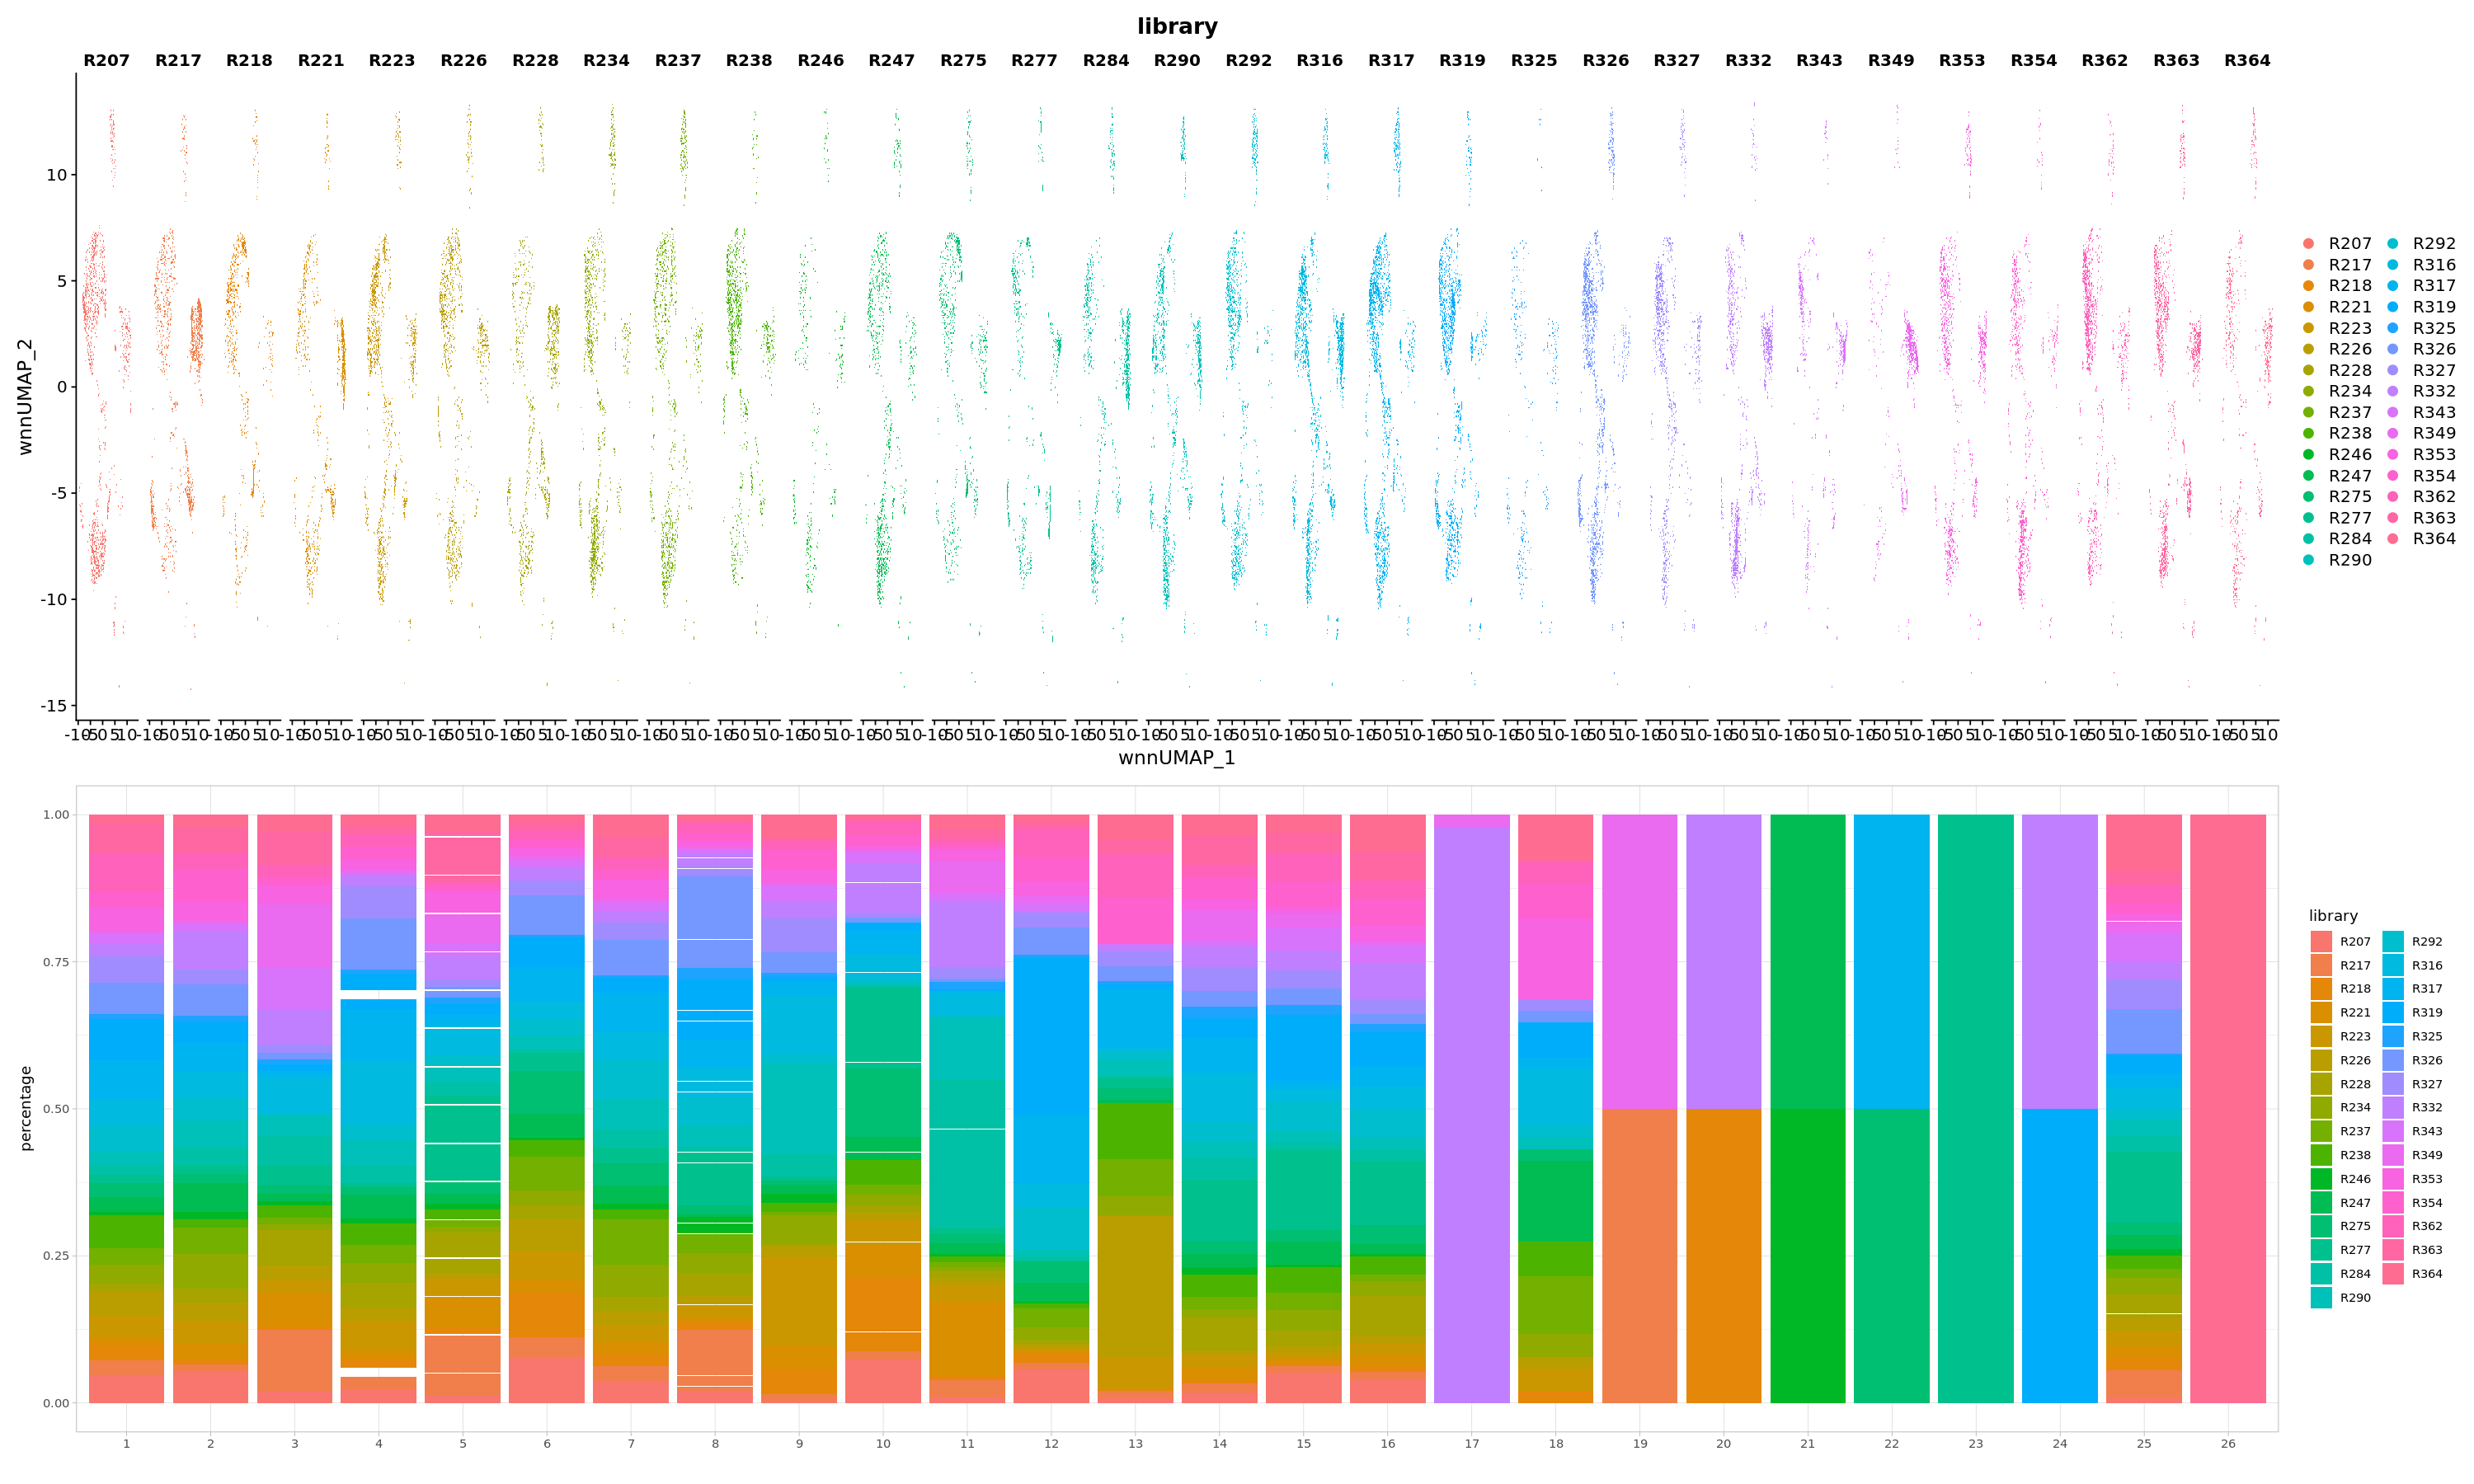

In [40]:
options(repr.plot.width=25, repr.plot.height=15)
p1 <- DimPlot(adata, reduction='umap.wnn', group.by='library', split.by='library', label=FALSE, label.size=6, repel=TRUE)
adata$value <- 1
p2 <- ggplot(adata[[]], aes(fill=library, y=value, x=seurat_clusters)) + geom_bar(position=position_fill(reverse=TRUE), stat='identity') + xlab('') + ylab('percentage') + theme_light()
p1 / p2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



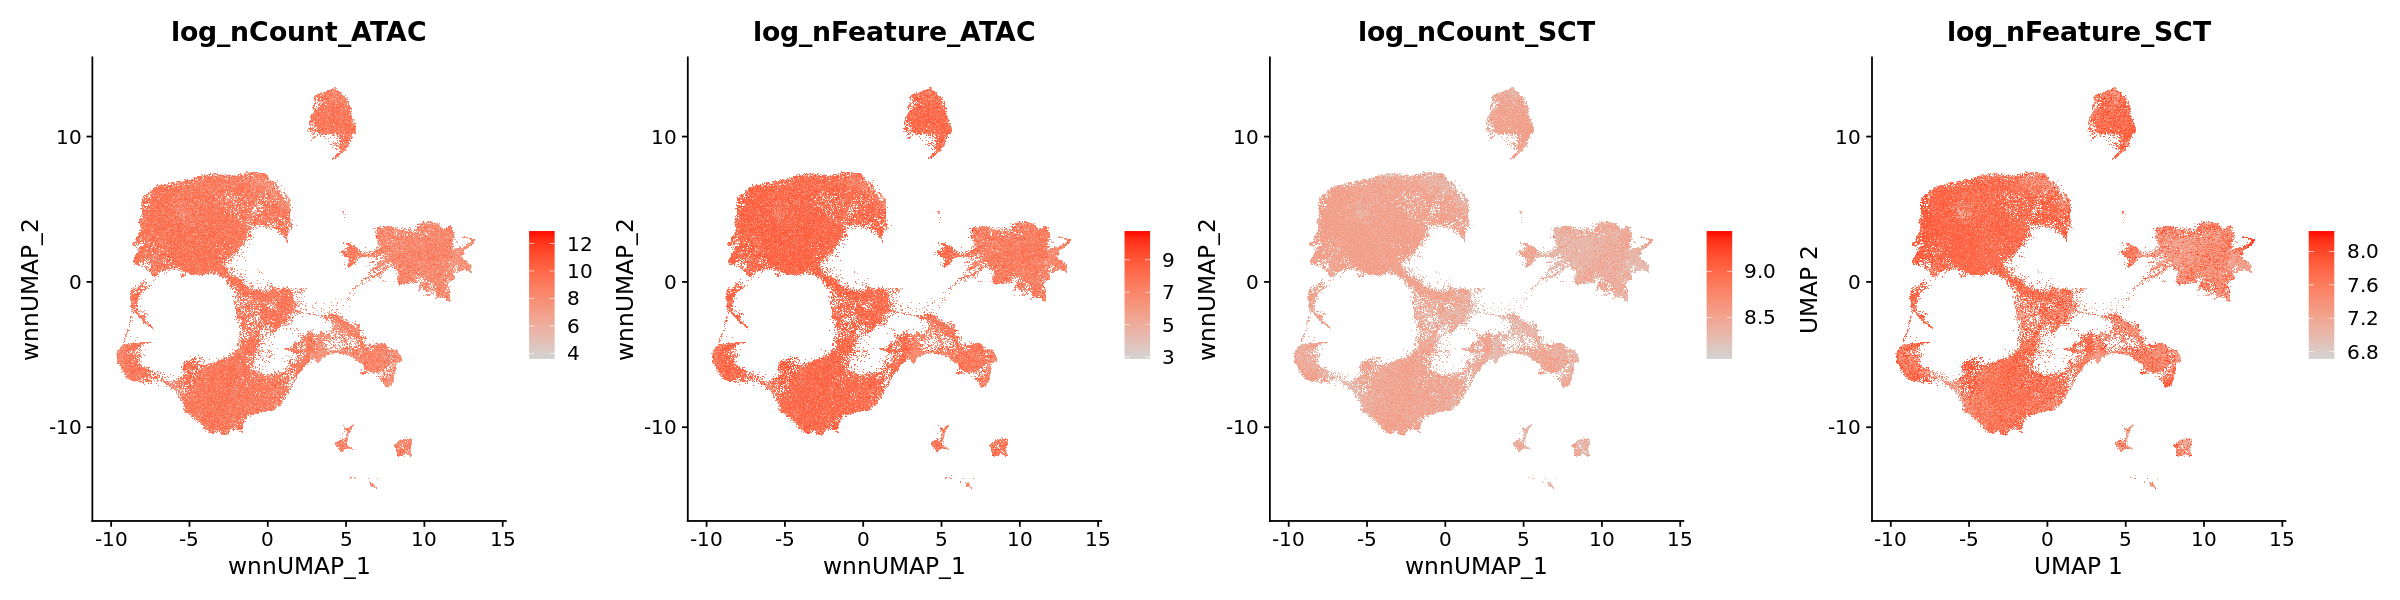

In [41]:
options(repr.plot.width=20, repr.plot.height=5)
p1 <- FeaturePlot(adata, reduction='umap.wnn', features=c('log_nCount_ATAC','log_nFeature_ATAC','log_nCount_SCT','log_nFeature_SCT'), 
                  cols=c('lightgrey', 'red'), ncol=4) + xlab('UMAP 1') + ylab('UMAP 2')
p1 & theme(plot.title=element_text(hjust=0.5))

Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"
Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"
Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"
Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"
Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"
Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"


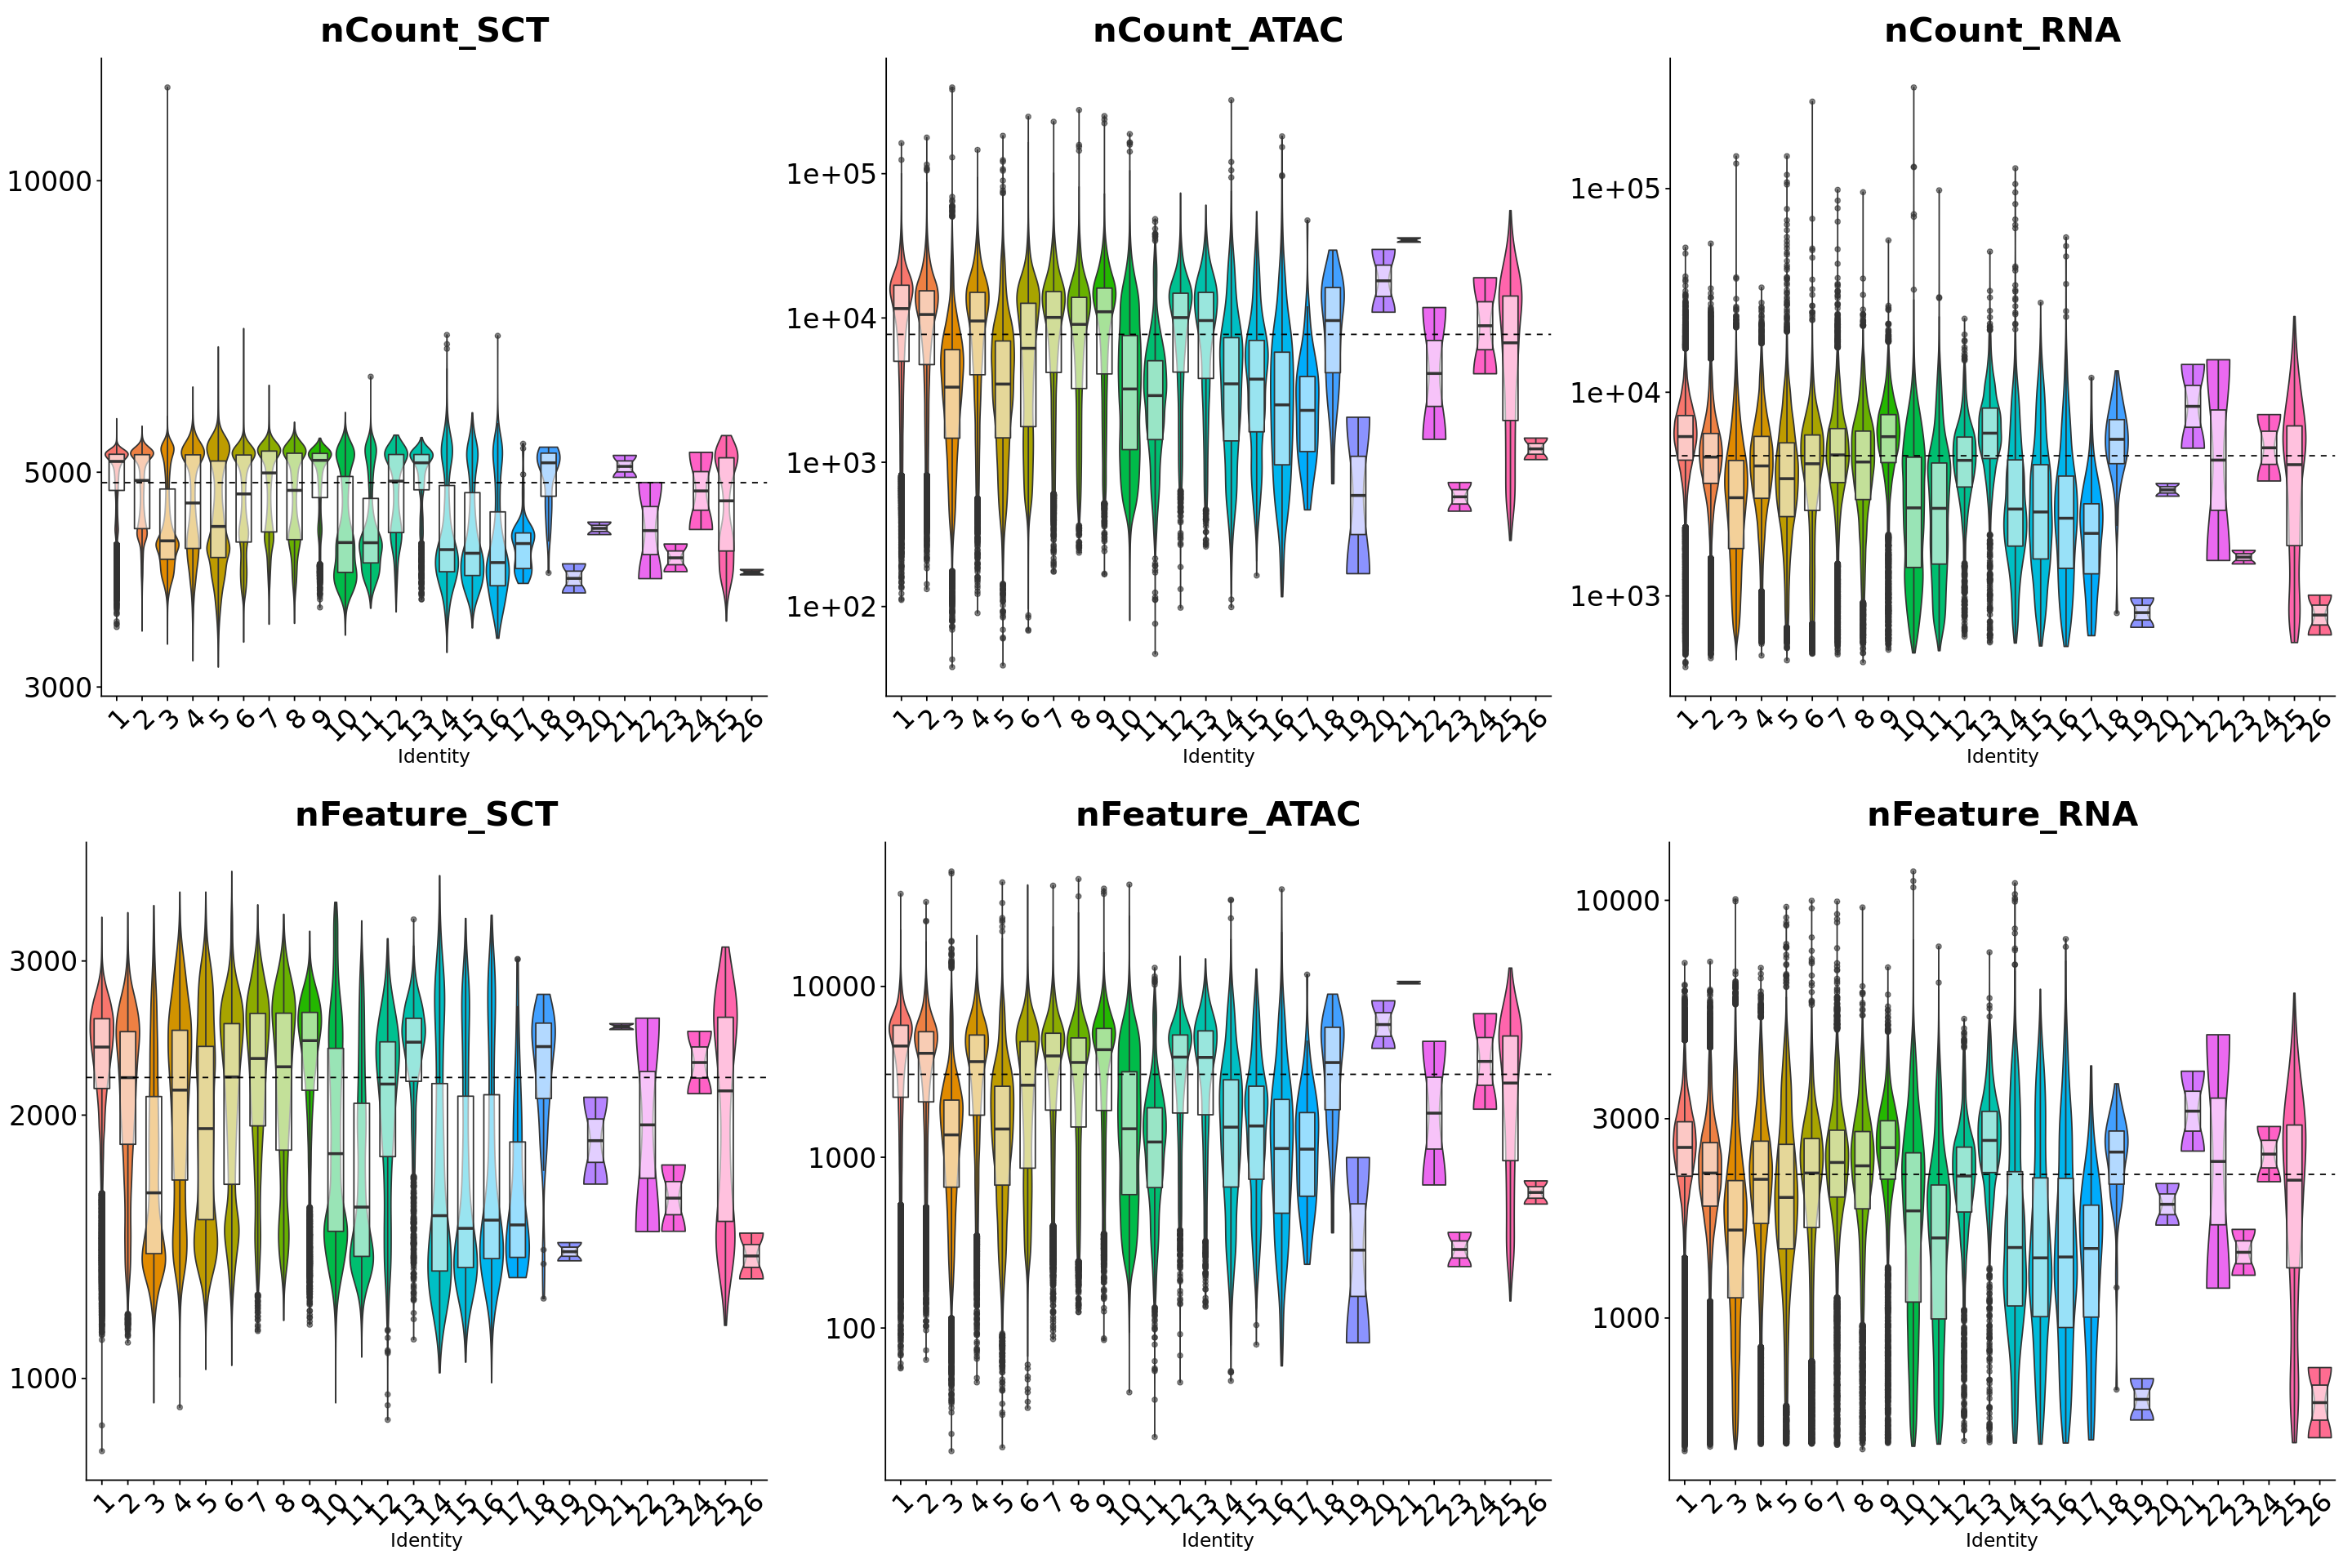

In [133]:
options(repr.plot.width=24, repr.plot.height=16)
p1 <- VlnPlot(adata, features='nCount_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_SCT), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
p2 <- VlnPlot(adata, features='nFeature_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_SCT), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
p3 <- VlnPlot(adata, features='nCount_ATAC', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_ATAC), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
p4 <- VlnPlot(adata, features='nFeature_ATAC', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_ATAC), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
p5 <- VlnPlot(adata, features='nCount_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_SCT), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
p6 <- VlnPlot(adata, features='nFeature_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_SCT), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
figure <- ggarrange(p1, p3, p5, p2, p4, p6, ncol = 3, nrow = 2,
                    common.legend = TRUE,legend="none")
figure

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

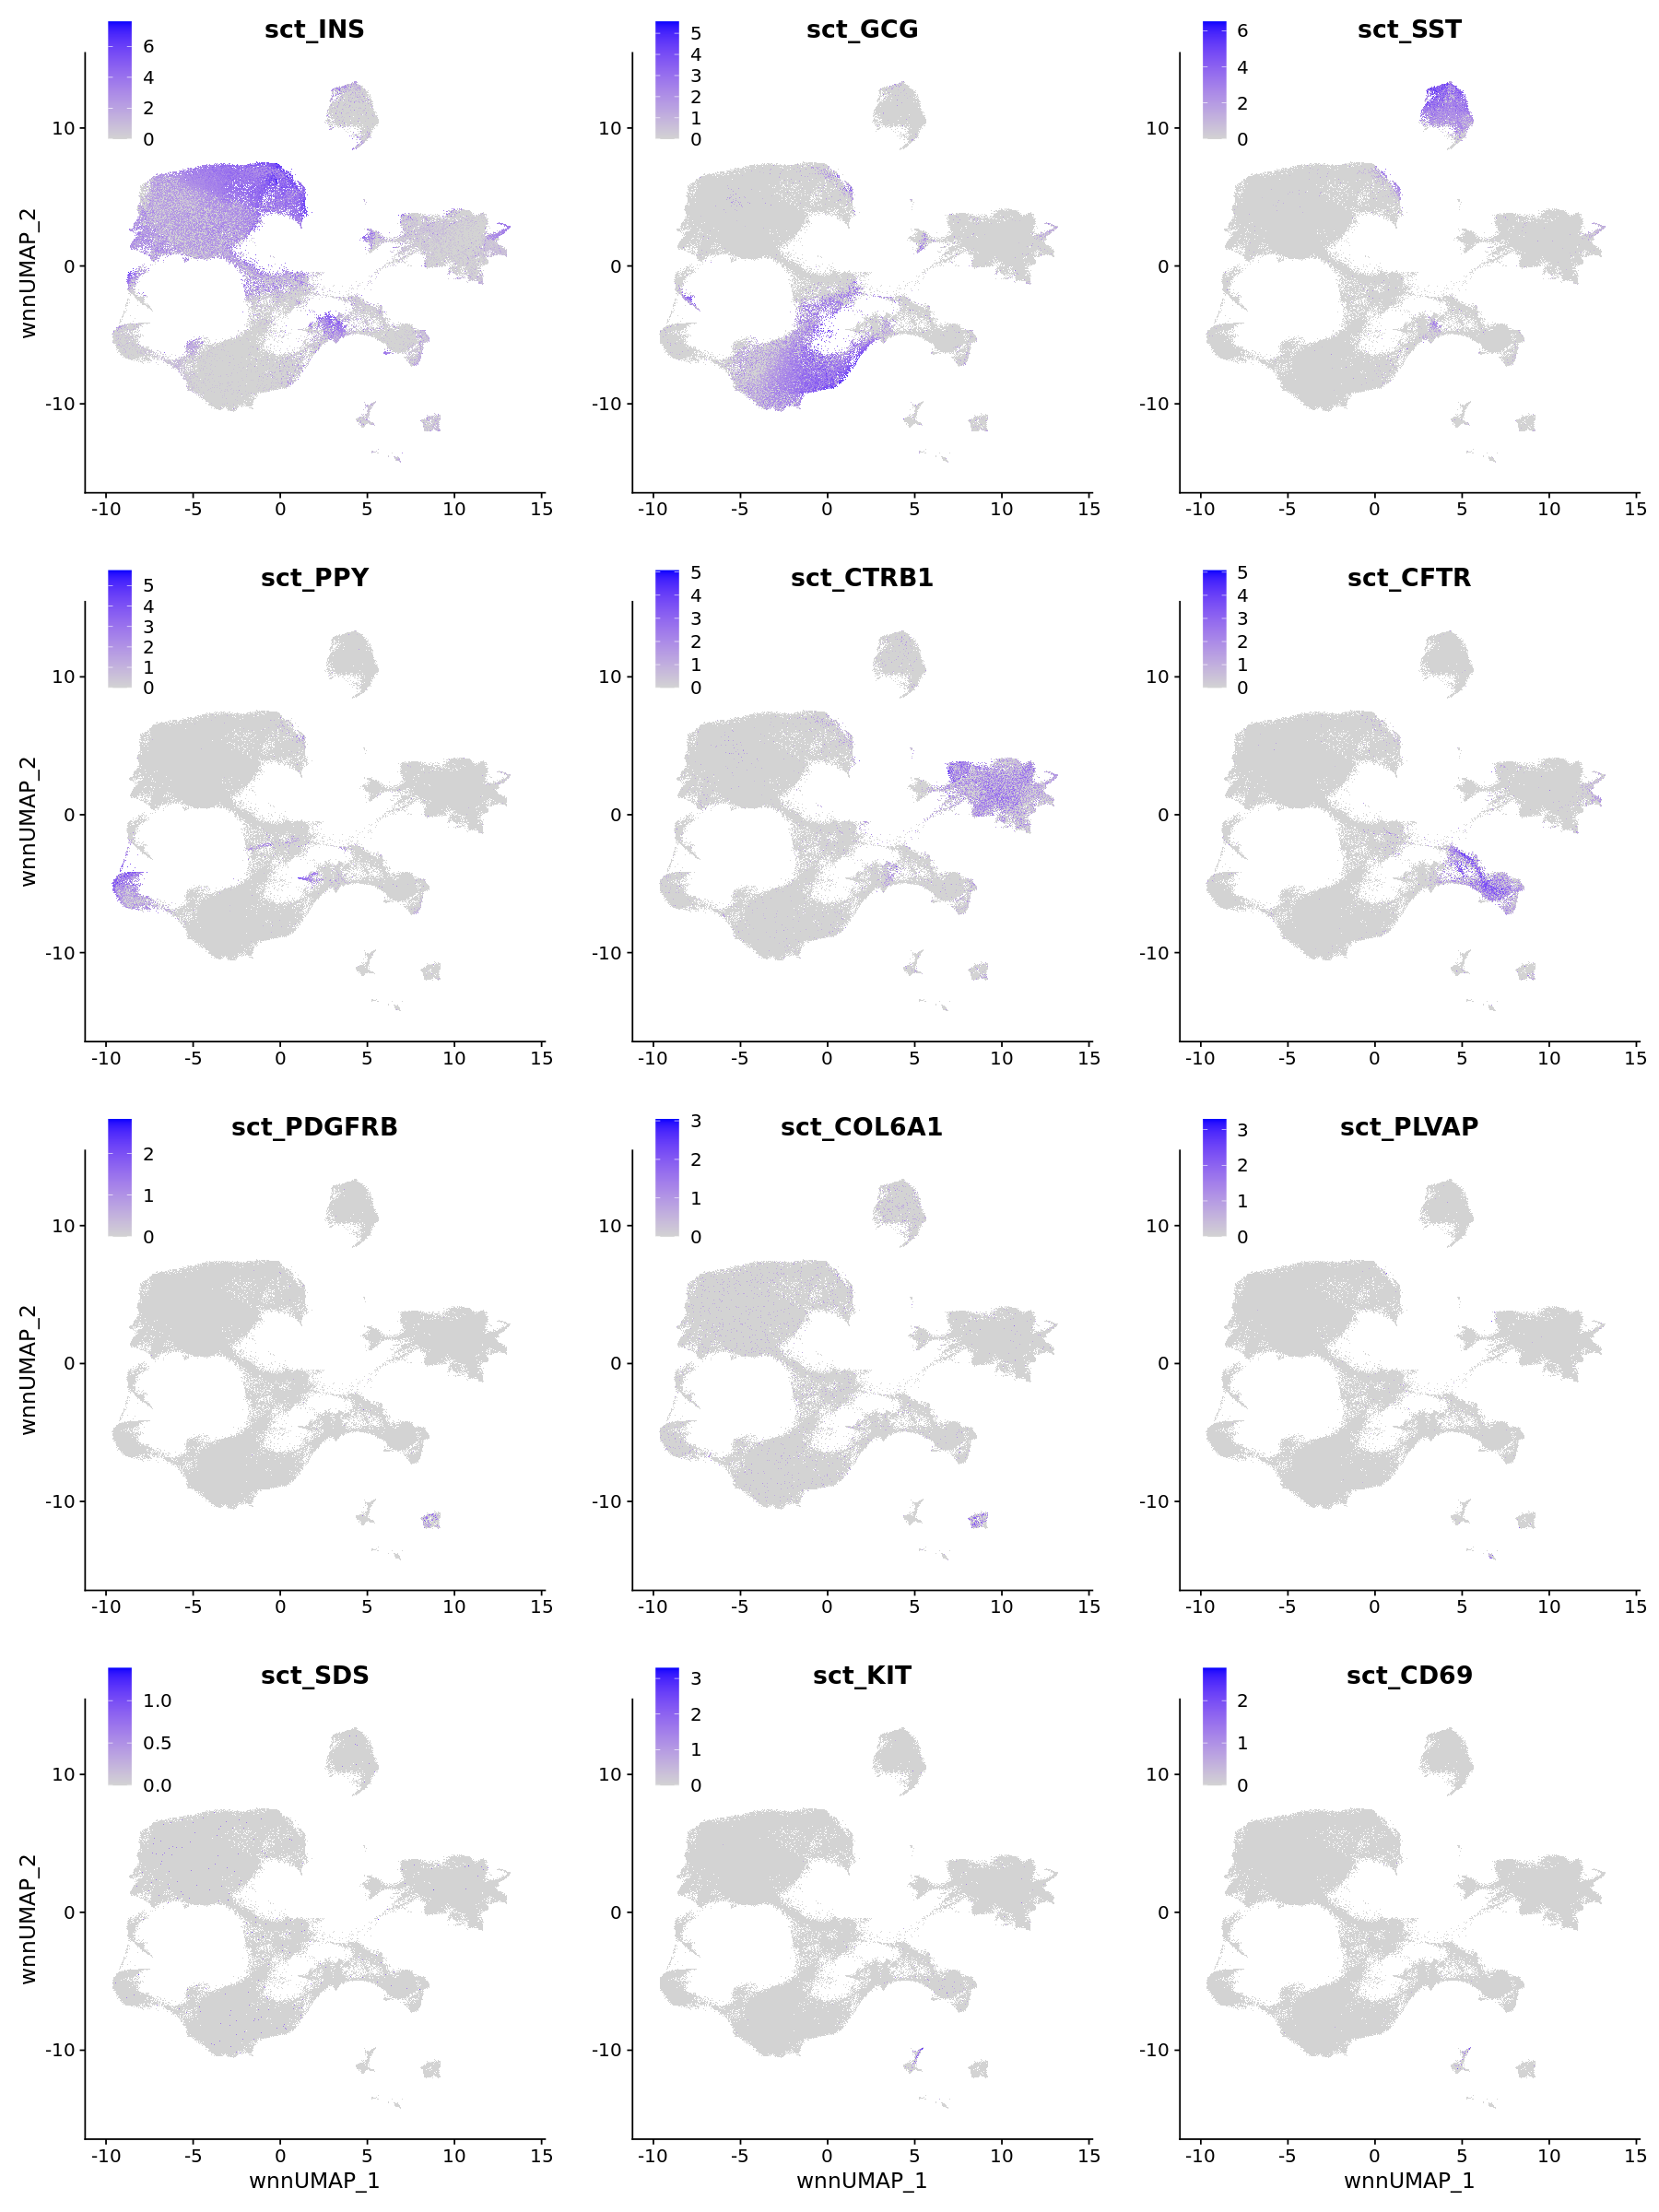

In [44]:
options(repr.plot.width=15, repr.plot.height=20)
p1 <- FeaturePlot(adata, reduction='umap.wnn', features=c('sct_INS','sct_GCG','sct_SST'), ncol=3)
p2 <- FeaturePlot(adata, reduction='umap.wnn', features=c('sct_PPY','sct_CTRB1','sct_CFTR'), ncol=3) 
p3 <- FeaturePlot(adata, reduction='umap.wnn', features=c('sct_PDGFRB','sct_COL6A1','sct_PLVAP'), ncol=3)
# p4 <- FeaturePlot(adata, reduction='umap.wnn', features=c('sct_SDS','sct_KIT','sct_MKI67'), ncol=3)
p4 <- FeaturePlot(adata, reduction='umap.wnn', features=c('sct_SDS','sct_KIT','sct_CD69'), ncol=3)

for (j in c(1,2,3)) {
    p1[[j]] <- p1[[j]] + xlab('')
    p2[[j]] <- p2[[j]] + xlab('')
    p3[[j]] <- p3[[j]] + xlab('')
}
for (j in c(2,3)) {
    p1[[j]] <- p1[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p2[[j]] <- p2[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p3[[j]] <- p3[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p4[[j]] <- p4[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p1[[1]] <- p1[[1]] + theme(legend.position = c(.05, .95))
    p2[[1]] <- p2[[1]] + theme(legend.position = c(.05, .95))
    p3[[1]] <- p3[[1]] + theme(legend.position = c(.05, .95))
    p4[[1]] <- p4[[1]] + theme(legend.position = c(.05, .95))
}
p1 / p2 / p3 / p4

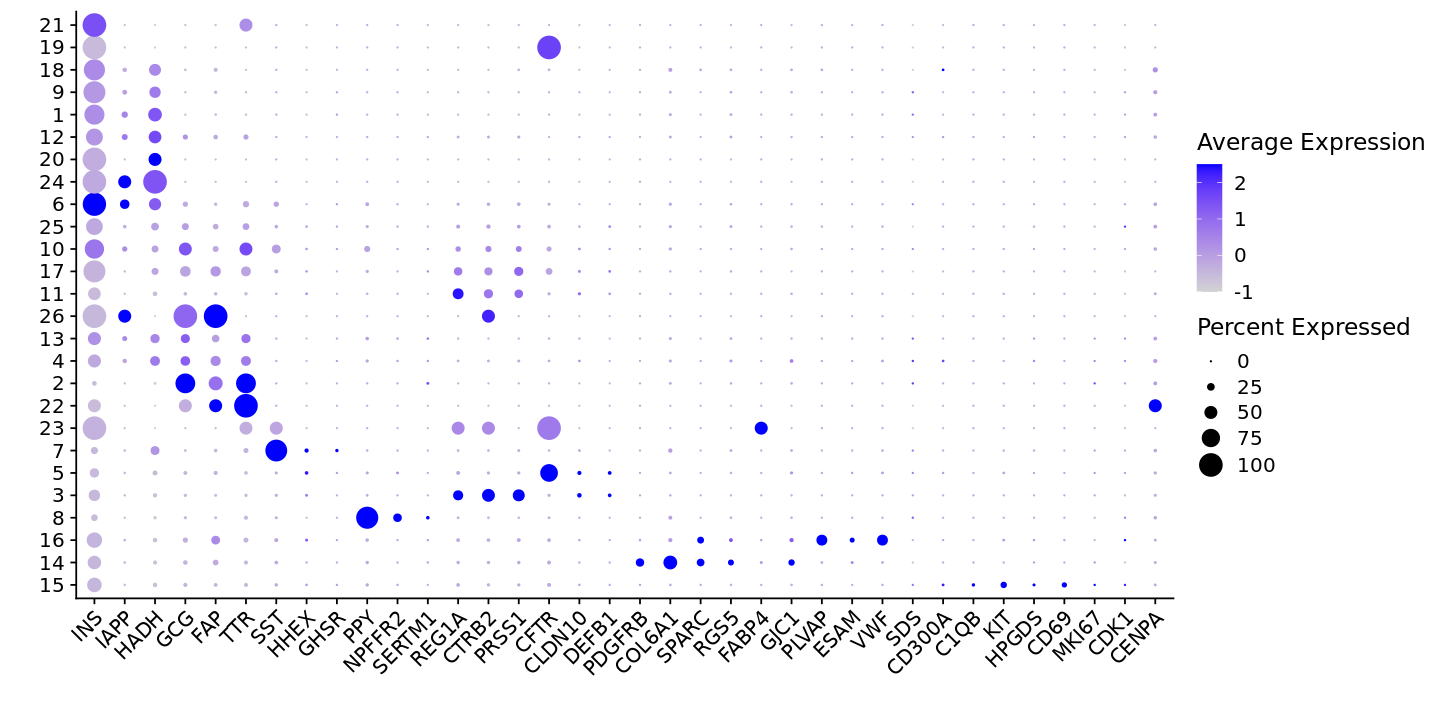

In [45]:
marker.genes <- c('INS','IAPP','HADH',
           'GCG','FAP','TTR',
           'SST','HHEX','GHSR',
           'PPY','NPFFR2','SERTM1',
           'REG1A','CTRB2','PRSS1',
           'CFTR','CLDN10','DEFB1',
           'PDGFRB','COL6A1','SPARC',
           'RGS5','FABP4','GJC1',
           'PLVAP','ESAM','VWF',
           'SDS','CD300A','C1QB',
           'KIT','HPGDS','CD69',
           'MKI67','CDK1','CENPA')
options(repr.plot.width=12, repr.plot.height=6)
p1 <- DotPlot(adata, assay='SCT', features=marker.genes, cluster.idents=TRUE) 
p1 <- p1 + theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
p1

In [ ]:
#moved to this dir at some point: 211016_combined_clusters_cleaning
outdir <- "/nfs/lab/hmummey/multiomic_islet/intermediates/211010_ATAC_HVW_tests/"
rds_fp2 <- file.path(outdir,"31sample_VariableFeature_HVWs_combined.rds")
saveRDS(adata, file = rds_fp2)

## New Marker Gene Plots

In [64]:
mg1_fp <- file.path(outdir,"markergenes1.txt")
markergenes1 <- scan(mg1_fp, what="", sep="\n")

In [68]:
markergenes1.2 <- markergenes1[-5]

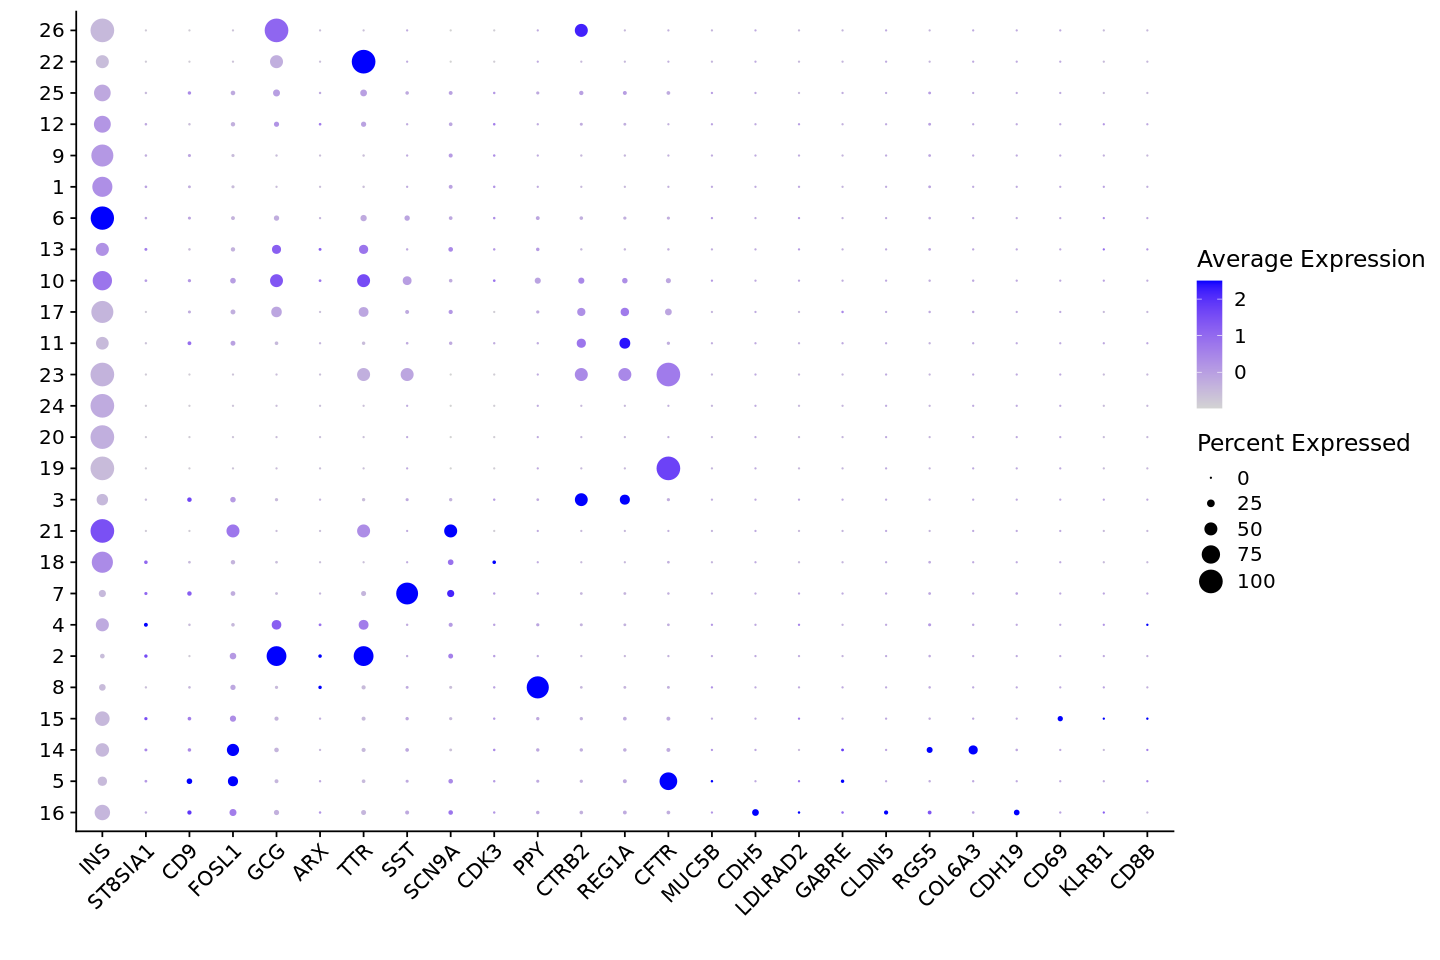

In [69]:
options(repr.plot.width=12, repr.plot.height=8)
p1 <- DotPlot(adata, assay='SCT', features=markergenes1.2, cluster.idents=TRUE) 
p1 <- p1 + theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
p1

In [46]:
head(Cells(adata))

[1] "R207_AAACAGCCAAACGGGC-1" "R207_AAACAGCCACAAAGAC-1"
[3] "R207_AAACAGCCAGCAAGTG-1" "R207_AAACAGCCAGGACCTT-1"
[5] "R207_AAACAGCCAGTTATCG-1" "R207_AAACAGCCATAATCCG-1"

In [131]:
length(Cells(adata))

[1] 251605

In [143]:
colnames(adata[[]])

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "nCount_ATAC"                       "nFeature_ATAC"                    
 [7] "gex_raw_reads"                     "gex_mapped_reads"                 
 [9] "gex_conf_intergenic_reads"         "gex_conf_exonic_reads"            
[11] "gex_conf_intronic_reads"           "gex_conf_exonic_unique_reads"     
[13] "gex_conf_exonic_antisense_reads"   "gex_conf_exonic_dup_reads"        
[15] "gex_exonic_umis"                   "gex_conf_intronic_unique_reads"   
[17] "gex_conf_intronic_antisense_reads" "gex_conf_intronic_dup_reads"      
[19] "gex_intronic_umis"                 "gex_conf_txomic_unique_reads"     
[21] "gex_umis_count"                    "gex_genes_count"                  
[23] "atac_raw_reads"                    "atac_unmapped_reads"              
[25] "atac_lowmapq"                      "atac_dup_reads"                   
[27] "atac_chimeric_reads"               "atac_mitochondrial_reads"         
[29] "atac_fragments"                    "atac_TSS_fragments"               
[31] "atac_peak_region_fragments"        "atac_peak_region_cutsites"        
[33] "TSS.enrichment"                    "TSS.percentile"                   
[35] "nCount_SCT"                        "nFeature_SCT"                     
[37] "SCT.weight"                        "ATAC.weight"                      
[39] "wsnn_res.0.2"                      "seurat_clusters"                  
[41] "log_nCount_ATAC"                   "log_nCount_SCT"                   
[43] "log_nFeature_ATAC"                 "log_nFeature_SCT"                 
[45] "library"                           "wsnn_res.0.25"                    
[47] "value"                             "sub.cluster"                      
[49] "multiplet"                         "remove_cells"

In [144]:
table(adata[[]]$seurat_clusters == 1)


 FALSE   TRUE 
178941  72664 

In [157]:
cluster_sizes <- as.data.frame(table(adata[[]]$seurat_clusters))
colnames(cluster_sizes) <- c("Cluster", "# Cells")
cluster_sizes[,]

Cluster # Cells
1  1       72664  
2  2       49717  
3  3       39166  
4  4       17834  
5  5       13568  
6  6       13408  
7  7       13172  
8  8        8120  
9  9        6176  
10 10       5798  
11 11       3649  
12 12       1904  
13 13       1781  
14 14       1645  
15 15       1590  
16 16        749  
17 17         91  
18 18         51  
19 19          2  
20 20          2  
21 21          2  
22 22          2  
23 23          2  
24 24          2  
25 25        508  
26 26          2

# Subclustering 

In [73]:
adata

An object of class Seurat 
120106 features across 251605 samples within 3 assays 
Active assay: ATAC (50000 features, 50000 variable features)
 2 other assays present: RNA, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [75]:
FindSubCluster2 <- function(
  object,
  cluster,
  graph.name,
  subcluster.name = "sub.cluster",
  resolution = 0.5,
  algorithm = 1
) {
  sub.cell <- WhichCells(object = object, idents = cluster)
  sub.graph <- as.Graph(x = object[[graph.name]][sub.cell, sub.cell])
  sub.clusters <- FindClusters(
    object = sub.graph,
    resolution = resolution,
    algorithm = algorithm,
    method = 'igraph'
  )
  sub.clusters[, 1] <- paste(cluster,  sub.clusters[, 1], sep = "_")
  object[[subcluster.name]] <- as.character(x = Idents(object = object))
  object[[subcluster.name]][sub.cell, ] <- sub.clusters[, 1]
  return(object)
}

In [82]:
Sys.time()

[1] "2021-10-14 18:30:48 UTC"

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from harmony.atac_ to harmonyatac_"


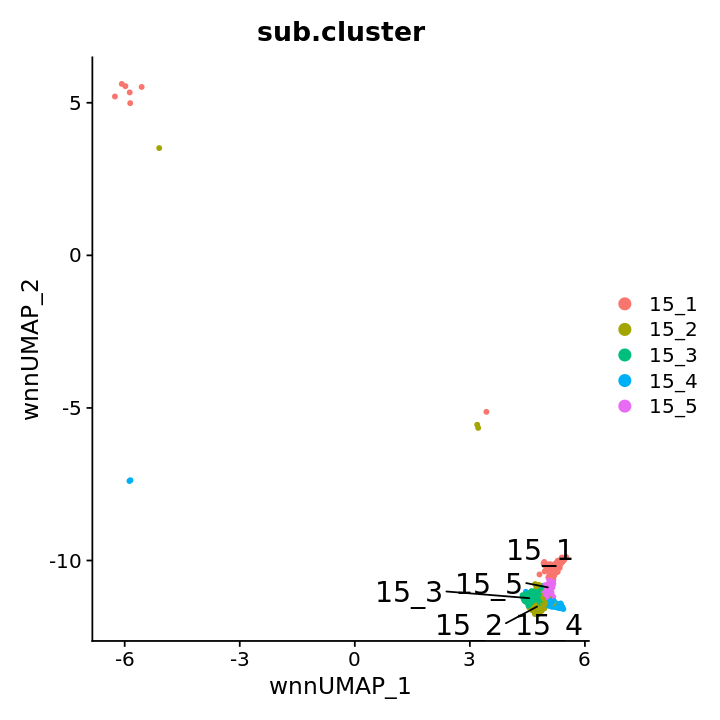

In [83]:
# subcluster to remove low quality cells

print(Sys.time())
sc.num <- 15

adata <- FindSubCluster2(adata, cluster=sc.num, algorithm=4, resolution=.5, graph.name='wsnn')
options(repr.plot.width=6, repr.plot.height=6)
adata.subset <- subset(adata, subset=seurat_clusters==sc.num)
print(Sys.time())
p1 <- DimPlot(adata.subset, reduction='umap.wnn', group.by='sub.cluster', label=TRUE, label.size=6, repel=TRUE)
p1

# options(repr.plot.width=10, repr.plot.height=40)
# p1 <- VlnPlot(adata, features='nCount_SCT', group.by='sub.cluster', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$nCount_SCT), linetype='dashed')
# p2 <- VlnPlot(adata, features='nFeature_SCT', group.by='sub.cluster', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$nFeature_SCT), linetype='dashed')
# p3 <- VlnPlot(adata, features='nCount_ATAC', group.by='sub.cluster', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$nCount_ATAC), linetype='dashed')
# p4 <- VlnPlot(adata, features='nFeature_ATAC', group.by='sub.cluster', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$nFeature_ATAC), linetype='dashed')
# p5 <- VlnPlot(adata, features='atac_mitochondrial_reads', group.by='sub.cluster', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$atac_mitochondrial_reads), linetype='dashed')
# p1 / p2 / p3 / p4 / p5

# marker.genes <- c('INS','IAPP','HADH',
#            'GCG','FAP','TTR',
#            'SST','HHEX','GHSR',
#            'PPY','NPFFR2','SERTM1','GHRL',
#            'REG1A','CTRB2','PRSS1',
#            'CFTR','CLDN10','DEFB1',
#            'PDGFRB','COL6A1','SPARC',
#            'RGS5','FABP4','GJC1',
#            'PLVAP','ESAM','VWF',
#            'SDS','CD300A','C1QB',
#            'KIT','HPGDS','CD69',
#            'MKI67','CDK1','CENPA')
# options(repr.plot.width=12, repr.plot.height=6)
# p1 <- DotPlot(adata.subset, assay='SCT', group.by='sub.cluster', features=marker.genes, cluster.idents=TRUE) 
# p1 <- p1 + theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
# p1

# options(repr.plot.width=10, repr.plot.height=5)
# p2 <- ggplot(adata.subset[[]], aes(fill=library, y=value, x=sub.cluster)) + geom_bar(position=position_fill(reverse=TRUE), stat='identity') + xlab('') + ylab('percentage') + theme_light()
# p2

In [84]:
Sys.time()

[1] "2021-10-14 18:32:28 UTC"

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from harmony.atac_ to harmonyatac_"
Warning message:
"ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


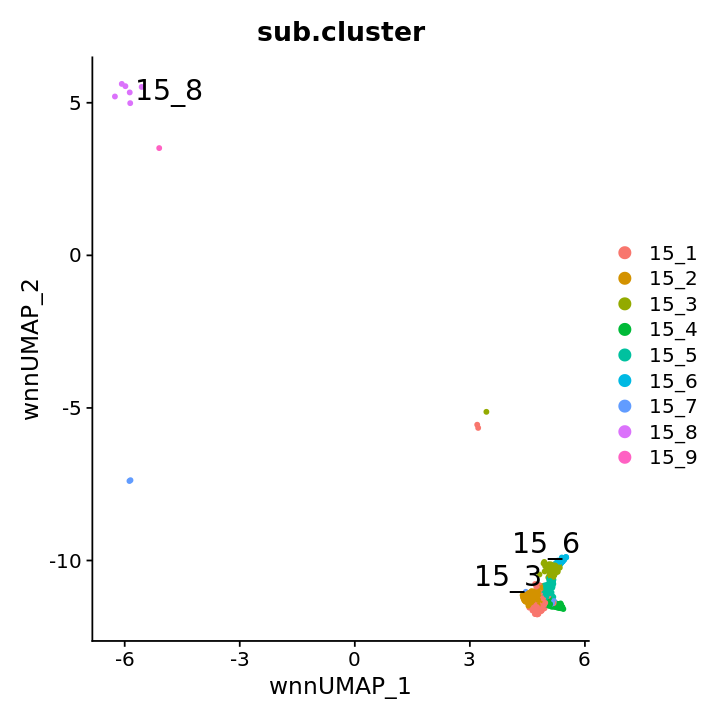

In [85]:
# subcluster to remove low quality cells

sc.num <- 15

adata <- FindSubCluster(adata, cluster=sc.num, algorithm=4, resolution=.5, graph.name='wsnn')
options(repr.plot.width=6, repr.plot.height=6)
adata.subset <- subset(adata, subset=seurat_clusters==sc.num)
p1 <- DimPlot(adata.subset, reduction='umap.wnn', group.by='sub.cluster', label=TRUE, label.size=6, repel=TRUE)
p1

In [86]:
Sys.time()

[1] "2021-10-14 18:32:40 UTC"

In [81]:
print(future(plan))

SequentialFuture:
Label: '<none>'
Expression:
plan
Lazy evaluation: FALSE
Asynchronous evaluation: FALSE
Local evaluation: TRUE
Environment: R_GlobalEnv
Capture standard output: TRUE
Capture condition classes: 'condition' (excluding 'nothing')
Globals: 1 objects totaling 364.43 KiB (function 'plan' of 364.43 KiB)
Packages: <none>
L'Ecuyer-CMRG RNG seed: <none> (seed = FALSE)
Resolved: TRUE
Value: 364.43 KiB of class 'function'
Early signaling: FALSE
Owner process: 311d73c9-34eb-e544-353f-f49149b02bbf
Class: 'SequentialFuture', 'UniprocessFuture', 'Future', 'environment'


Testing a few other options, to figure out what was causing the problem

In [ ]:
Sys.time()

In [90]:
options(future.globals.maxSize = 420000 * 1024^2)
#print(options(future.globals.maxSize))

In [91]:
# subcluster to remove low quality cells

sc.num <- 1

adata <- FindSubCluster(adata, cluster=sc.num, algorithm=4, resolution=.5, graph.name='wsnn')
options(repr.plot.width=6, repr.plot.height=6)
adata.subset <- subset(adata, subset=seurat_clusters==sc.num)
p1 <- DimPlot(adata.subset, reduction='umap.wnn', group.by='sub.cluster', label=TRUE, label.size=6, repel=TRUE)
p1

ERROR: Error in asMethod(object): Cholmod error 'problem too large' at file ../Core/cholmod_dense.c, line 102


Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from harmony.atac_ to harmonyatac_"


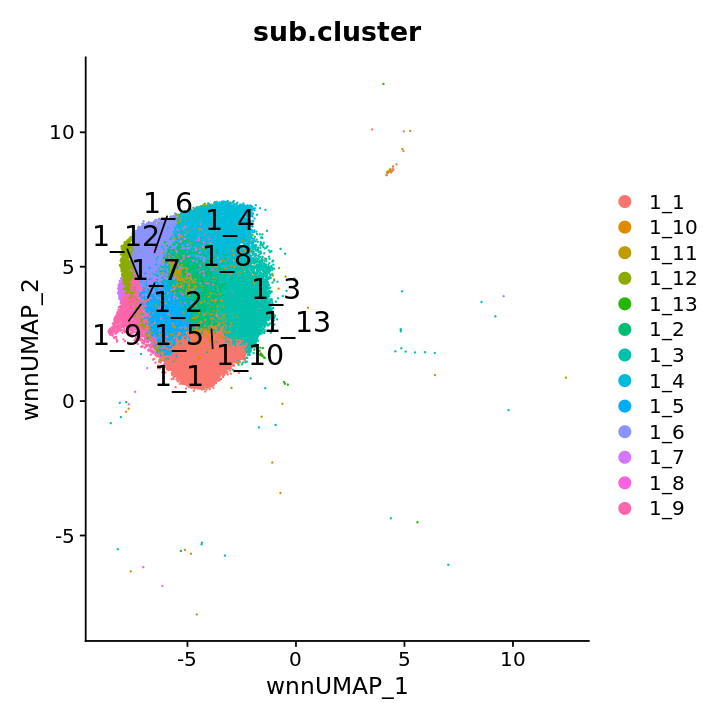

In [102]:
# subcluster to remove low quality cells

sc.num <- 1

adata <- FindSubCluster2(adata, cluster=sc.num, algorithm=4, resolution=.5, graph.name='wsnn')
options(repr.plot.width=6, repr.plot.height=6)
adata.subset <- subset(adata, subset=seurat_clusters==sc.num)
p1 <- DimPlot(adata.subset, reduction='umap.wnn', group.by='sub.cluster', label=TRUE, label.size=6, repel=TRUE)
p1

In [104]:
# subcluster to remove low quality cells

sc.num <- c(1)

adata <- FindSubCluster(adata, cluster=sc.num, algorithm=4, resolution=.5, graph.name='wsnn')
options(repr.plot.width=6, repr.plot.height=6)
adata.subset <- subset(adata, subset=seurat_clusters==sc.num)
p1 <- DimPlot(adata.subset, reduction='umap.wnn', group.by='sub.cluster', label=TRUE, label.size=6, repel=TRUE)
p1

ERROR: Error in asMethod(object): Cholmod error 'problem too large' at file ../Core/cholmod_dense.c, line 102


## Removing Doublets
Adapted from Katha's notebook: `/nfs/lab/katha/multiomics/notebooks/amulet_testing_multi-2-forHannah.ipynb`

In [94]:
suppressMessages(library(textclean))
suppressMessages(library(ggplot2))
suppressMessages(library(MASS))
suppressMessages(library(stringr))
suppressMessages(library(mclust))

In [99]:
#read in multiplet barcodes from amulet outputs
multiplets <- read.table("/nfs/lab/katha/multiomics/amulet_zip/amulet_outputs/combined_barcodes.txt") %>% t() %>% as.vector()
head(multiplets)
length(multiplets)

[1] "R226_AAACCGCGTTGCACAA-1" "R226_AACAGGATCGGCTATG-1"
[3] "R226_AGAGATTAGGCATTAC-1" "R226_AGCACTTAGTAGCGGG-1"
[5] "R226_AGCACTTAGTATCGCG-1" "R226_AGCAGGTAGGTTTGAC-1"

[1] 18615

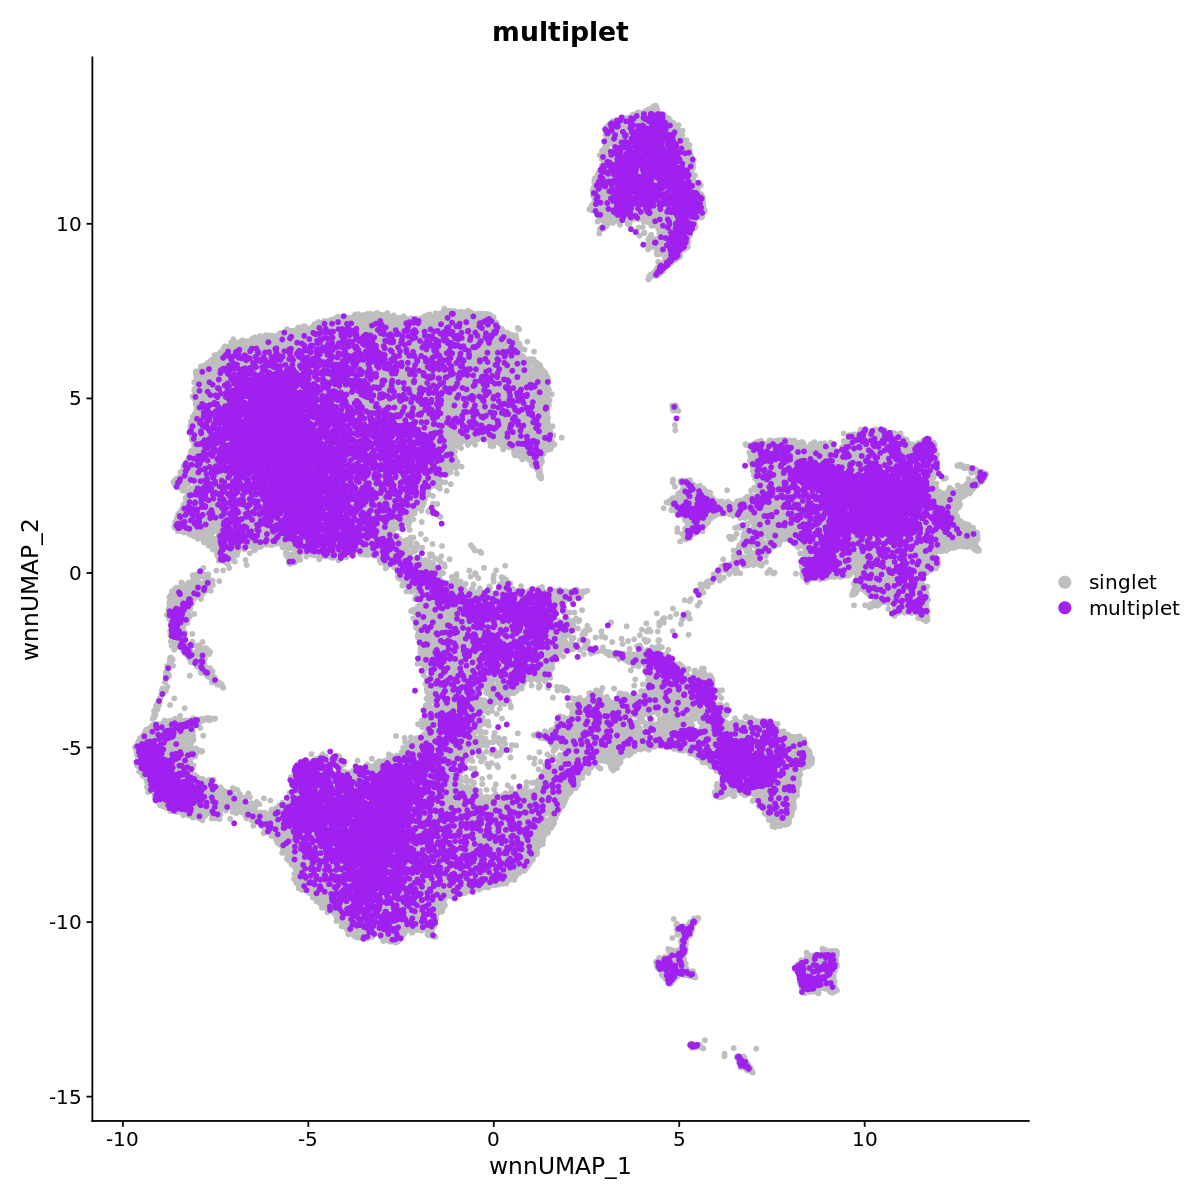

In [146]:
#mark multiplets in adata 
cells <- Cells(adata)
#head(cells)
multiplet.metadata <- rep("singlet", length(cells))
names(multiplet.metadata) <- cells
multiplet.metadata[multiplets] <- "multiplet"

#plot multiplets overlaid on the combined CUMAP
adata <- AddMetaData(adata, multiplet.metadata, col.name="multiplet")
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction='umap.wnn', group.by = "multiplet", pt.size = 1, raster=FALSE,
        cols = c("singlet" = "grey", "multiplet" = "purple"), 
        order = c("multiplet", "singlet"))

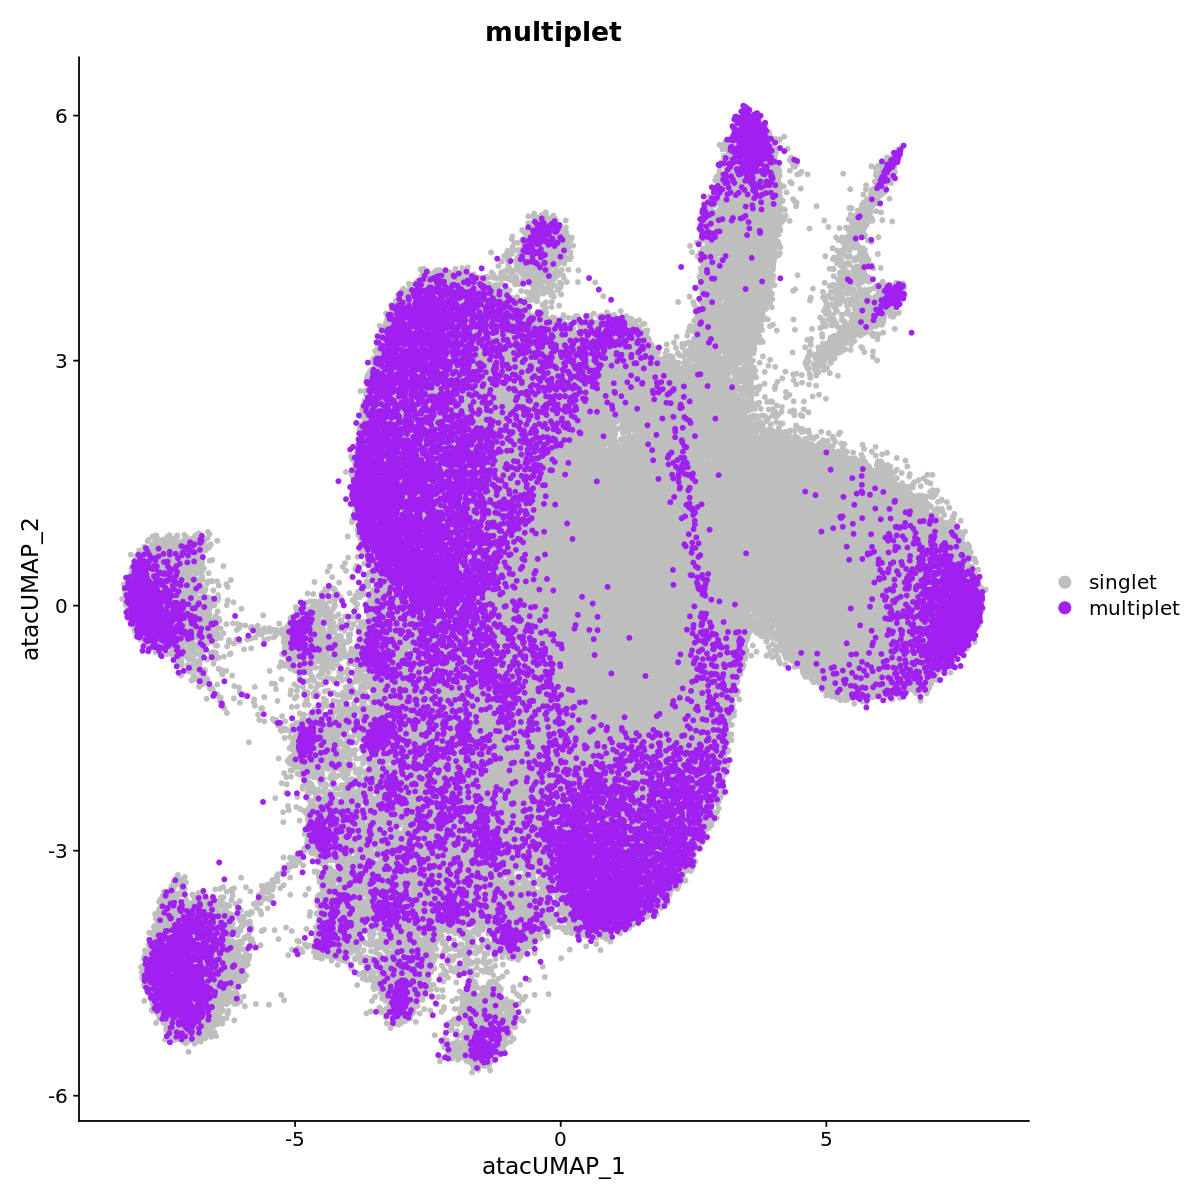

In [158]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction='umap.atac', group.by = "multiplet", pt.size = 1, raster=FALSE,
        cols = c("singlet" = "grey", "multiplet" = "purple"), 
        order = c("multiplet", "singlet"))

In [112]:
adata

An object of class Seurat 
120106 features across 251605 samples within 3 assays 
Active assay: ATAC (50000 features, 50000 variable features)
 2 other assays present: RNA, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [111]:
#remove doublets!
#remove multiplet cells from amulet output
adata$remove_cells <- (Cells(adata) %in% multiplets)
adata2 <- subset(adata, subset=remove_cells==FALSE)
adata2

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from harmony.atac_ to harmonyatac_"


An object of class Seurat 
120106 features across 233003 samples within 3 assays 
Active assay: ATAC (50000 features, 50000 variable features)
 2 other assays present: RNA, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [114]:
Sys.time()

[1] "2021-10-14 21:41:24 UTC"

In [115]:
# RNA analysis
DefaultAssay(adata2) <- 'RNA'
suppressWarnings(adata2 <- SCTransform(adata2, verbose=FALSE))
adata2 <- RunPCA(adata2)
adata2 <- RunHarmony(adata2, group.by.vars='library', assay.use='SCT', reduction.save='harmony.rna')
adata2 <- RunUMAP(adata2, dims=1:50, reduction='harmony.rna', reduction.name='umap.rna', reduction.key='rnaUMAP_')
#adata <- RunUMAP(dims=1:50, reduction.name='umap.rna', reduction.key='rnaUMAP_')

# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(adata2) <- 'ATAC'
adata2 <- RunTFIDF(adata2)
adata2 <- FindTopFeatures(adata2, min.cutoff='q0', verbose=FALSE)
adata2 <- RunSVD(adata2)
hm_atac <- HarmonyMatrix(Embeddings(adata2, reduction='lsi'), adata$library, do_pca=FALSE)
adata2[['harmony.atac']] <- CreateDimReducObject(embeddings=hm_atac, key='atac_', assay='ATAC')
adata2 <- RunUMAP(adata2, dims=2:50, reduction='harmony.atac', reduction.name='umap.atac', reduction.key='atacUMAP_')

PC_ 1 
Positive:  INS, ZNF385D, SST, TRPM3, PAM, RIMS2, KCNMB2, GPC6, PDE4D, ENPP2 
	   MAGI2, RFX3, GCG, NRXN1, LINC01099, NRG1, CADM1, DGKB, SNTG1, RGS7 
	   SYT16, DPP6, SPAG16, FGF14, KCNB2, CNTN5, LSAMP, LRRTM4, NLGN1, SOX5 
Negative:  GP2, NEAT1, PRSS2, CPA1, CELA3A, REG1A, CTRB2, CEL, CD44, PRSS1 
	   PNLIPRP1, CTRB1, MECOM, CPB1, CPA2, SPINK1, CUZD1, CHRM3, CLPS, NIBAN1 
	   CELA3B, RAB27B, REG1B, CA12, AKAP13, TC2N, RBPJL, PNLIP, SH3RF2, ZFP36L1 
PC_ 2 
Positive:  GP2, PRSS2, CPA1, CELA3A, CTRB2, CEL, PNLIPRP1, REG1A, PRSS1, CPB1 
	   CPA2, CTRB1, CLPS, CUZD1, CELA3B, ZNF385D, SPINK1, MECOM, REG1B, PNLIP 
	   PLA2G1B, CHRM3, RBPJL, CA12, HSPH1, TRPM3, PAM, TRHDE, CTRC, PDK4 
Negative:  MT-CO3, MT-CO2, MT-ATP6, PKHD1, MT-ND3, CFTR, MT-CO1, SLC4A4, MT-CYB, BICC1 
	   MT-ND4, MT-ND1, MT-ND2, BARX2, THSD4, MACC1, ADAMTS9, ADAMTS9-AS2, CD44, MT-ND5 
	   MYOF, NCEH1, ABTB2, RUNX1, ZEB2, TFPI2, TJP2, CXCL8, PMEPA1, WWTR1 
PC_ 3 
Positive:  MT-CO3, MT-CO2, MT-ND3, INS, MT-ATP6, MT-CO1

ERROR: Error in HarmonyMatrix(Embeddings(adata2, reduction = "lsi"), adata$library, : meta_data must be either a data.frame or a vector with batch 
                values for each cell


In [ ]:
adata2

In [ ]:
Sys.time()

In [ ]:
# Combining Modalities
#adata <- FindMultiModalNeighbors(adata, reduction.list=list('pca', 'lsi'), dims.list=list(1:50, 2:50))
adata2 <- FindMultiModalNeighbors(adata2, reduction.list=list('harmony.rna', 'harmony.atac'), dims.list=list(1:50, 2:50))
adata2 <- RunUMAP(adata2, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
adata2 <- FindClusters(adata2, graph.name='wsnn', algorithm=4,  resolution = 0.25, verbose=FALSE, method = 'igraph')

adata2$log_nCount_ATAC=log(adata2$nCount_ATAC)
adata2$log_nCount_SCT=log(adata2$nCount_SCT)
adata2$log_nFeature_ATAC=log(adata2$nFeature_ATAC)
adata2$log_nFeature_SCT=log(adata2$nFeature_SCT)

In [ ]:
Sys.time()

In [ ]:
adata2

In [ ]:
adata2[["ATAC"]]

In [130]:
length(Cells(adata2))

[1] 233003

In [160]:
outdir <- "/nfs/lab/hmummey/multiomic_islet/intermediates/211010_ATAC_HVW_tests/"
rds_fp3 <- file.path(outdir,"31sample_VariableFeature_HVWs_combined.no_doublets.rds")
saveRDS(adata2, file = rds_fp3)

## Visualize clustering

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
"ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


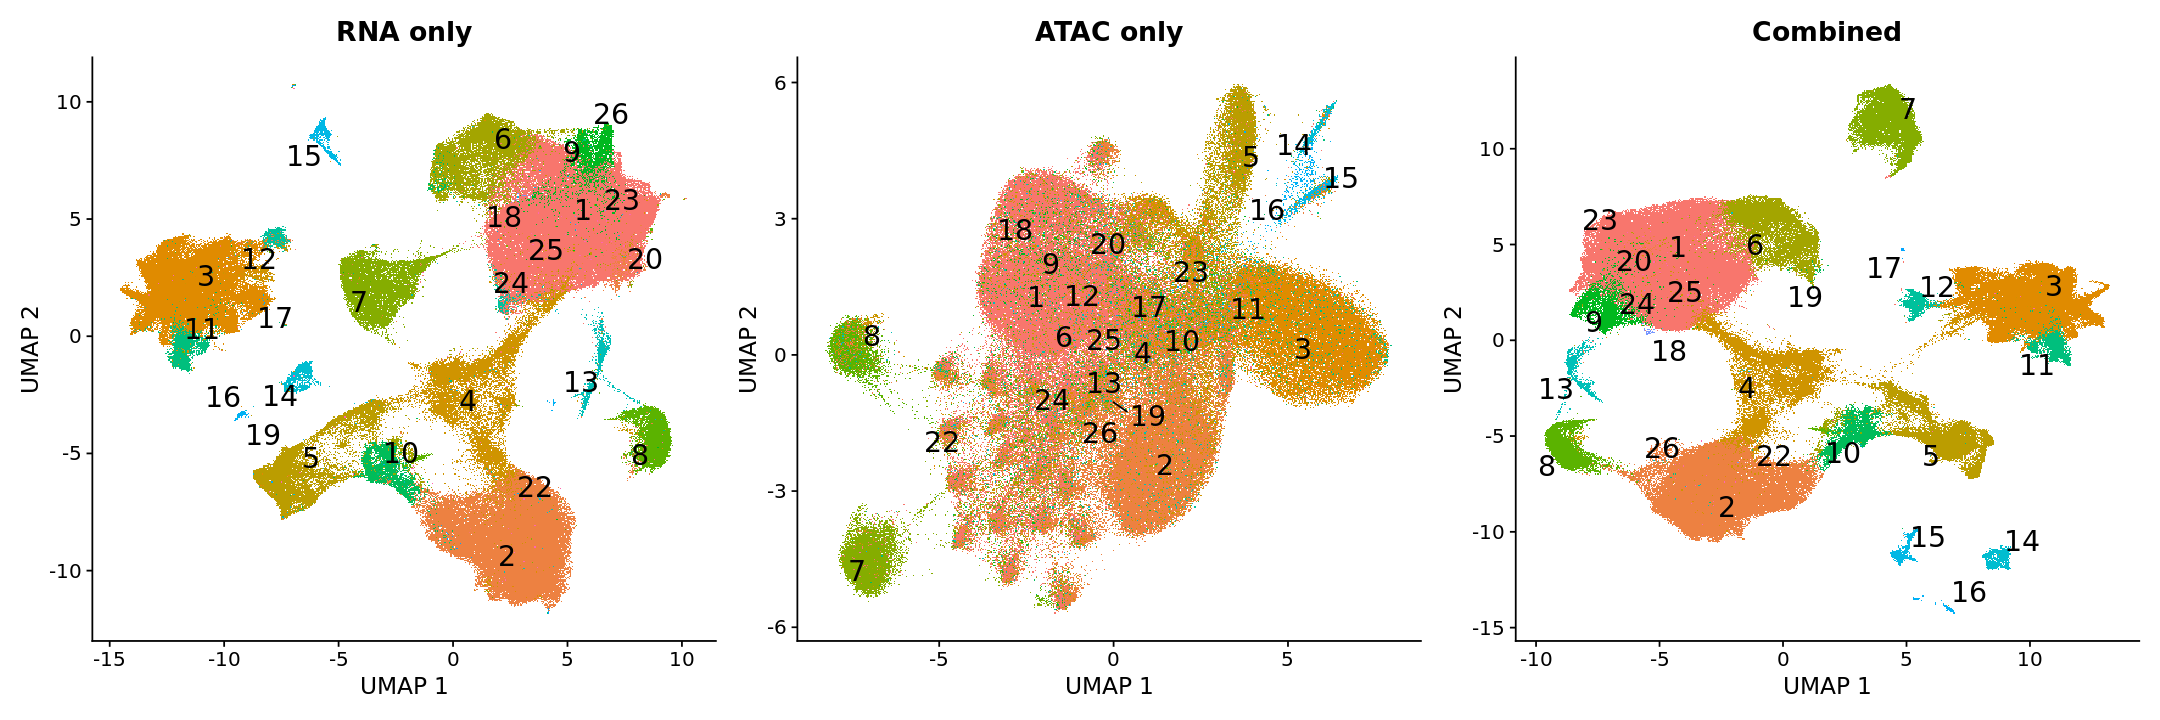

In [116]:
options(repr.plot.width=18, repr.plot.height=6)
p1 <- DimPlot(adata2, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata2, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata2, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

In [149]:
length(Cells(adata2))

[1] 233003

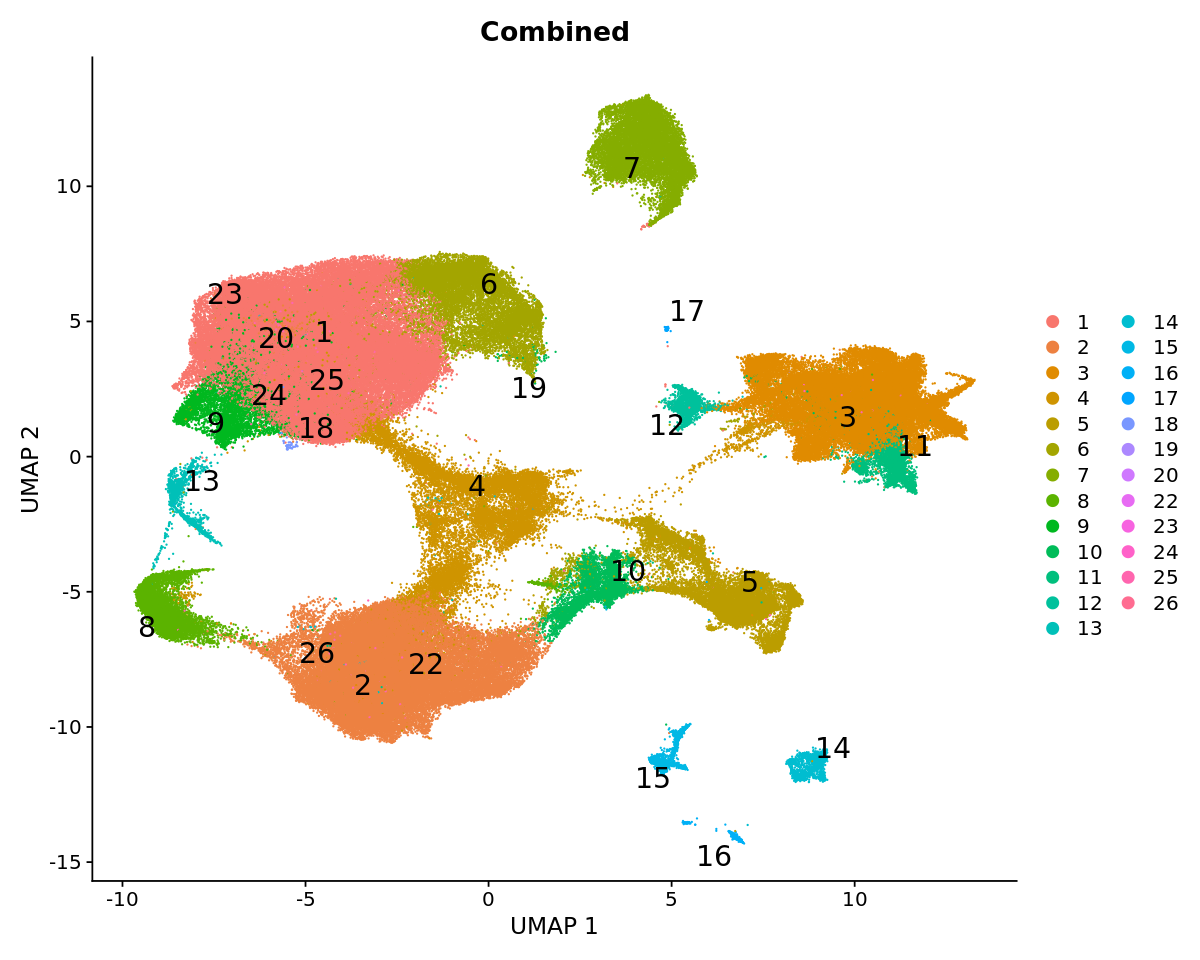

In [148]:
options(repr.plot.width=10, repr.plot.height=8)
p3 <- DimPlot(adata2, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE, raster=FALSE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p3

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



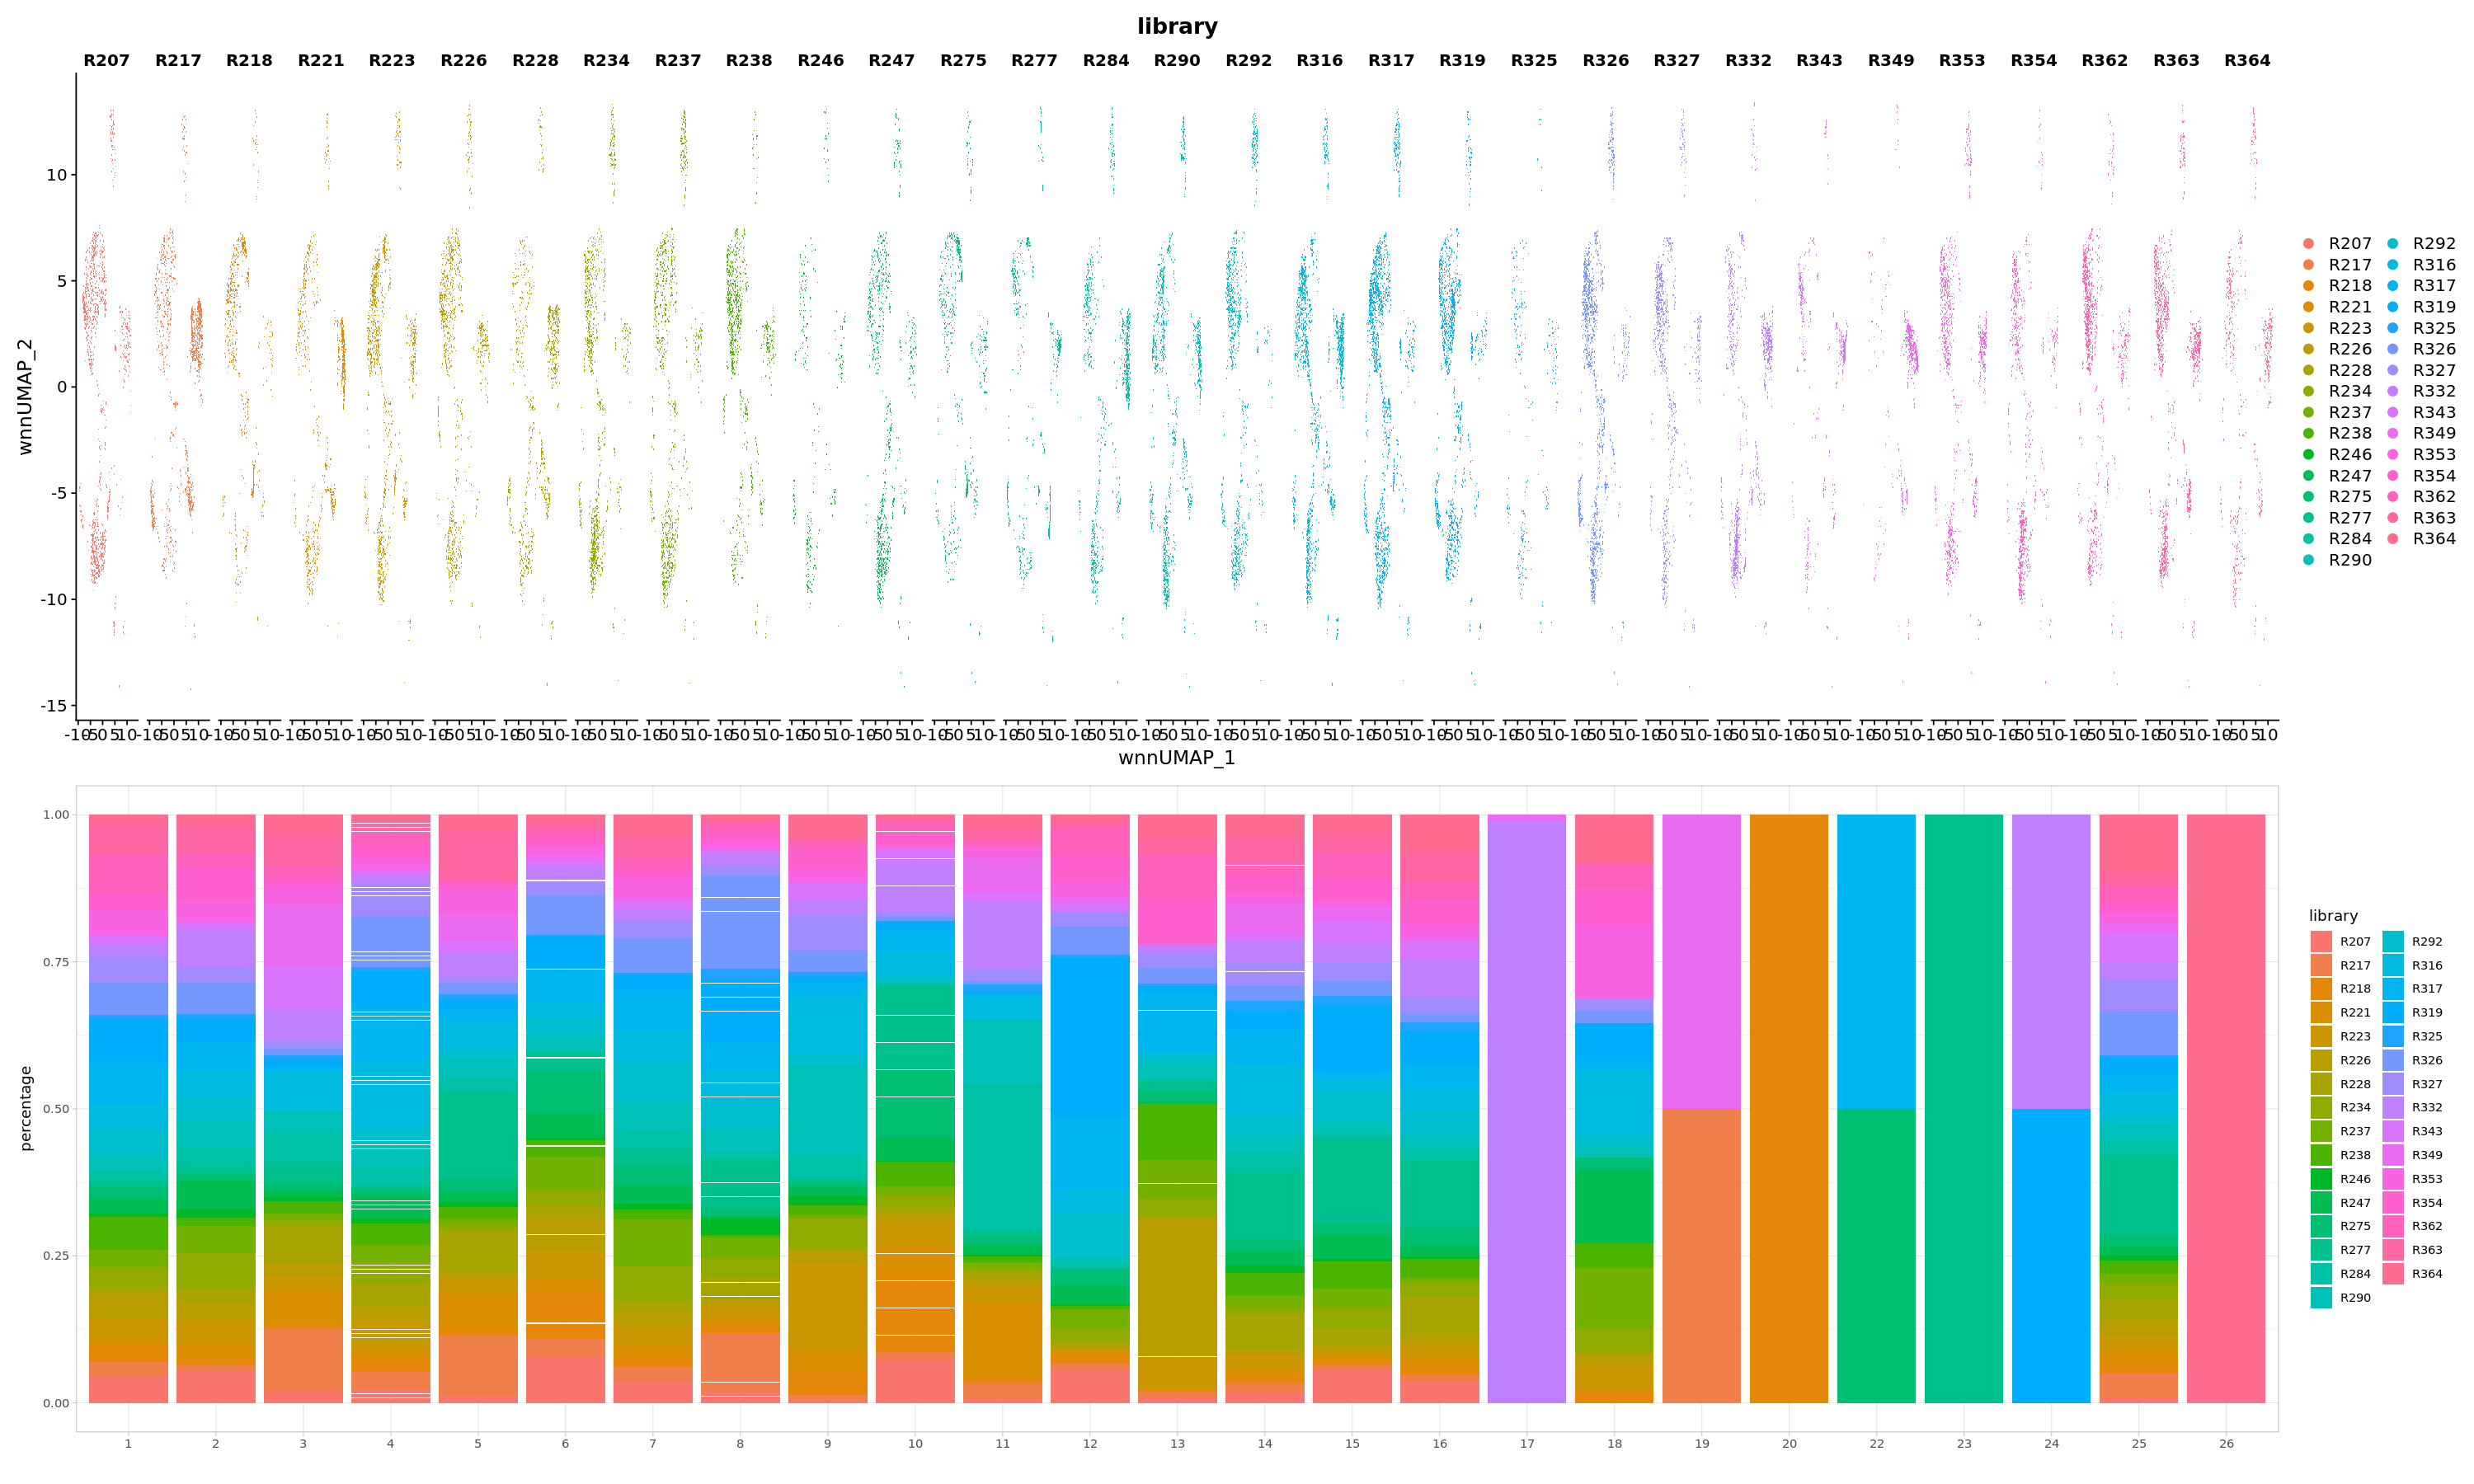

In [118]:
options(repr.plot.width=25, repr.plot.height=15)
p1 <- DimPlot(adata2, reduction='umap.wnn', group.by='library', split.by='library', label=FALSE, label.size=6, repel=TRUE)
adata$value <- 1
p2 <- ggplot(adata2[[]], aes(fill=library, y=value, x=seurat_clusters)) + geom_bar(position=position_fill(reverse=TRUE), stat='identity') + xlab('') + ylab('percentage') + theme_light()
p1 / p2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



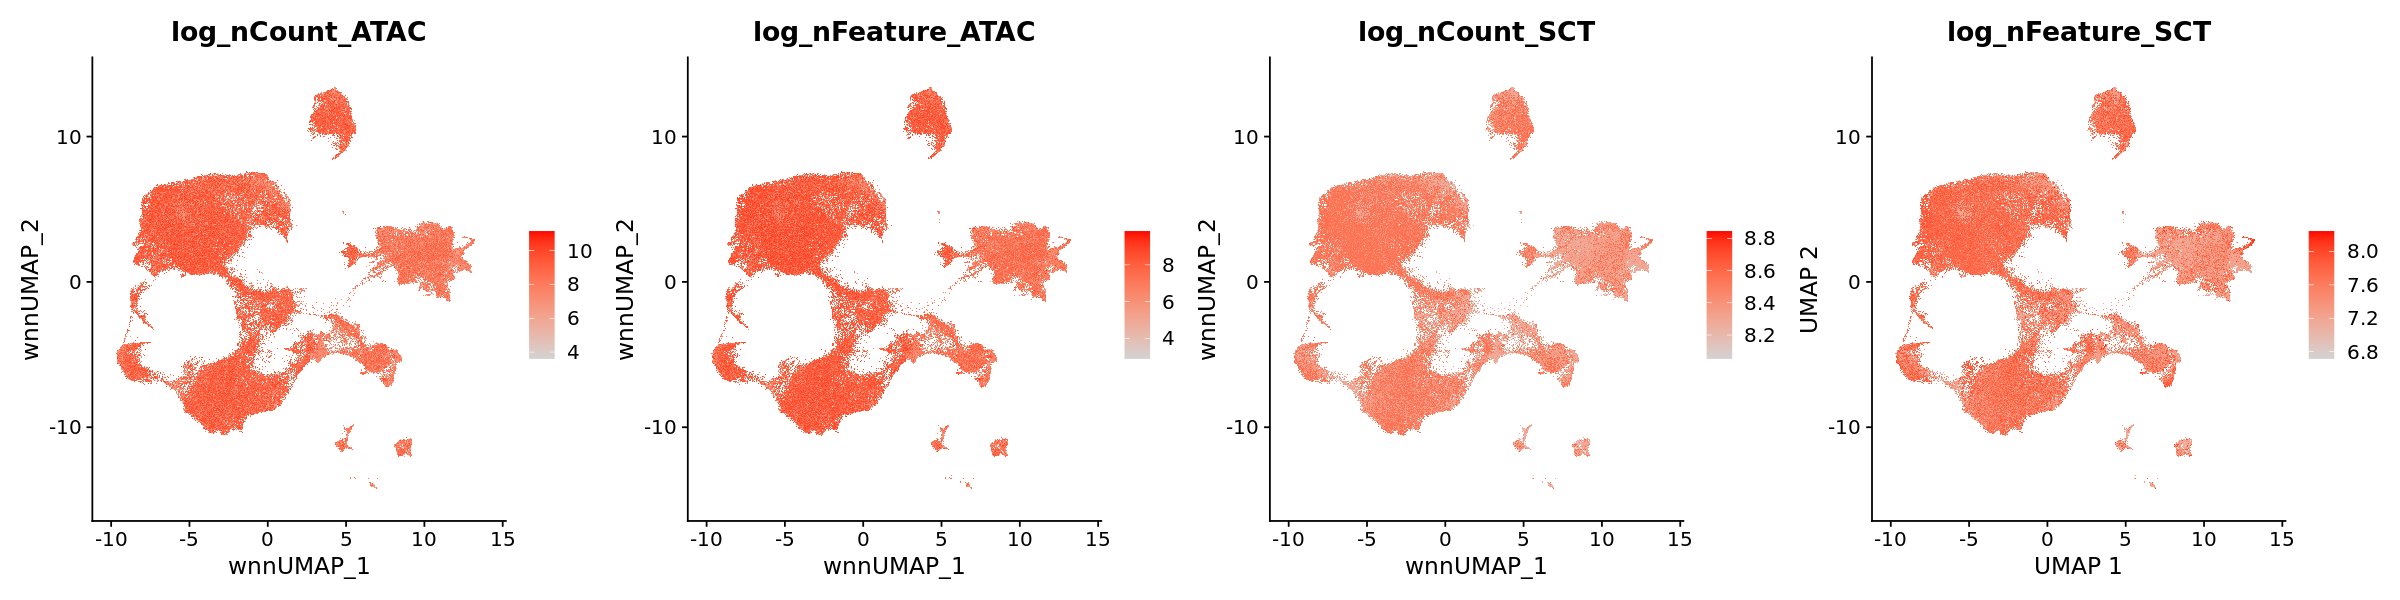

In [119]:
options(repr.plot.width=20, repr.plot.height=5)
p1 <- FeaturePlot(adata2, reduction='umap.wnn', features=c('log_nCount_ATAC','log_nFeature_ATAC','log_nCount_SCT','log_nFeature_SCT'), 
                  cols=c('lightgrey', 'red'), ncol=4) + xlab('UMAP 1') + ylab('UMAP 2')
p1 & theme(plot.title=element_text(hjust=0.5))

Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"
Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"
Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"
Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"
Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"
Warning message:
"Ignoring unknown parameters: pt.size"
Warning message:
"Ignoring unknown parameters: lw"
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data 

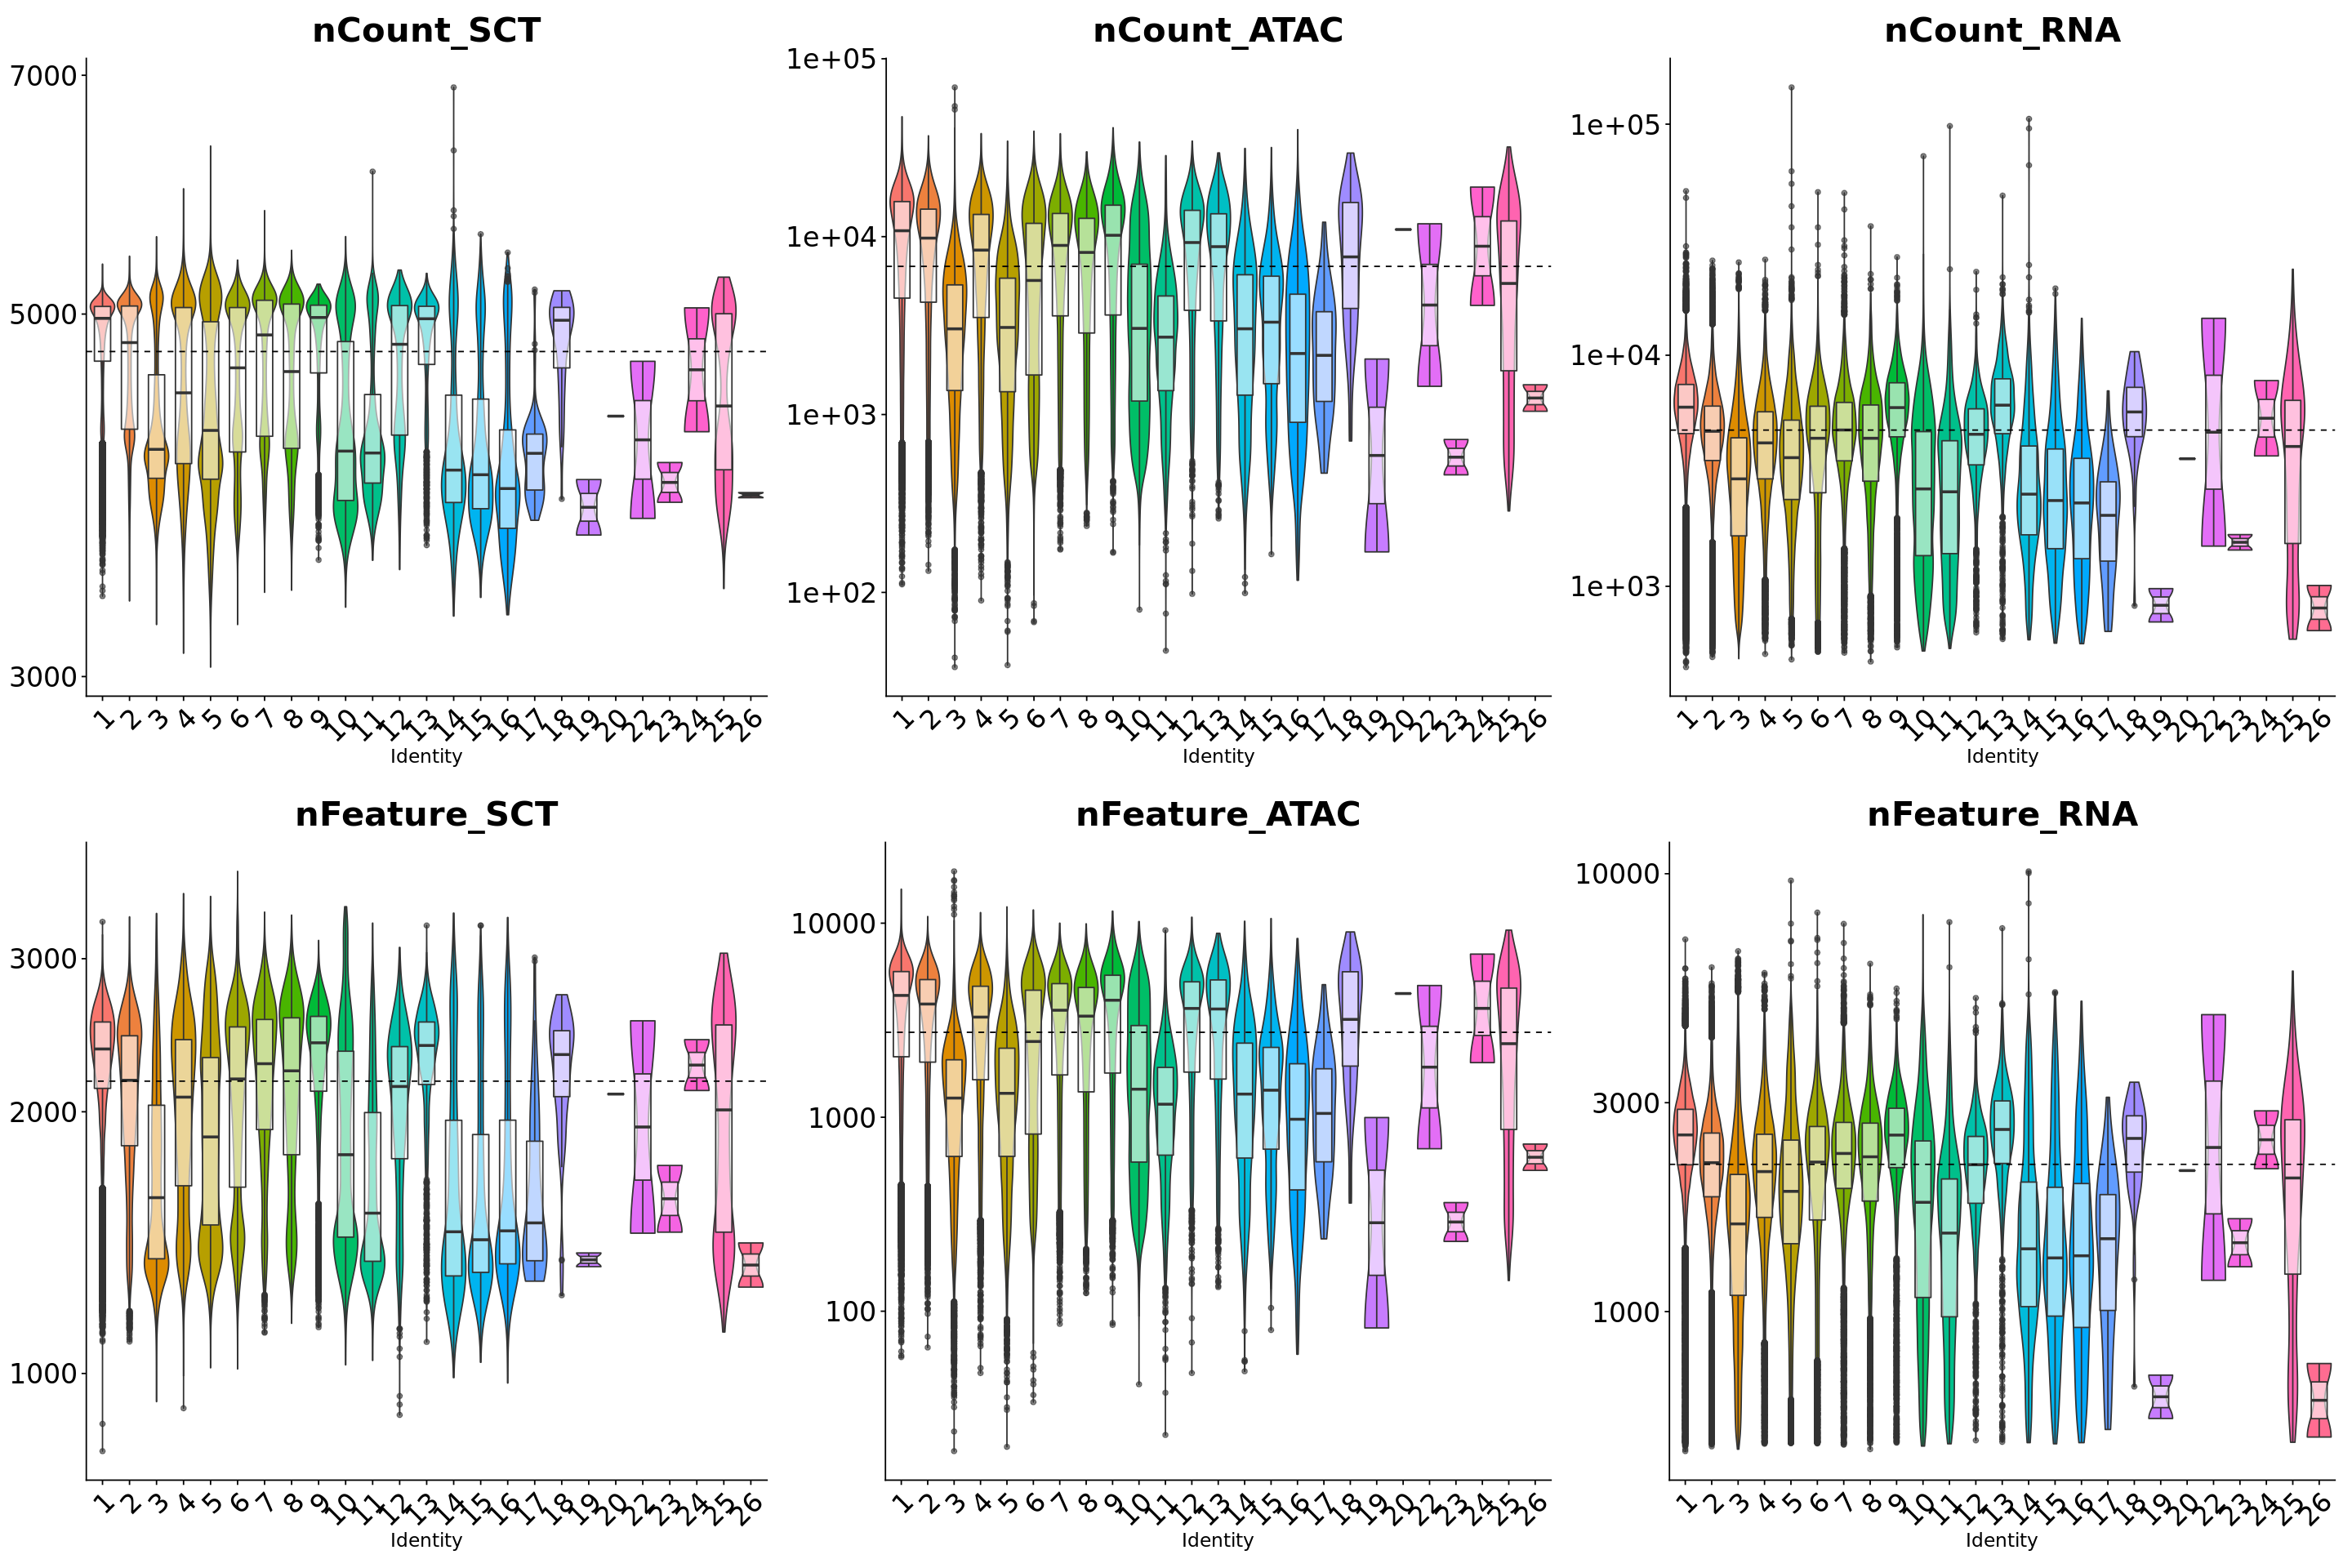

In [147]:
options(repr.plot.width=24, repr.plot.height=16)
p1 <- VlnPlot(adata2, features='nCount_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata2$nCount_SCT), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
p2 <- VlnPlot(adata2, features='nFeature_SCT', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata2$nFeature_SCT), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
p3 <- VlnPlot(adata2, features='nCount_ATAC', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata2$nCount_ATAC), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
p4 <- VlnPlot(adata2, features='nFeature_ATAC', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata2$nFeature_ATAC), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
p5 <- VlnPlot(adata2, features='nCount_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata2$nCount_SCT), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
p6 <- VlnPlot(adata2, features='nFeature_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata2$nFeature_SCT), linetype='dashed', lw=2) + 
  theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
figure <- ggarrange(p1, p3, p5, p2, p4, p6, ncol = 3, nrow = 2,
                    common.legend = TRUE,legend="none")
figure

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

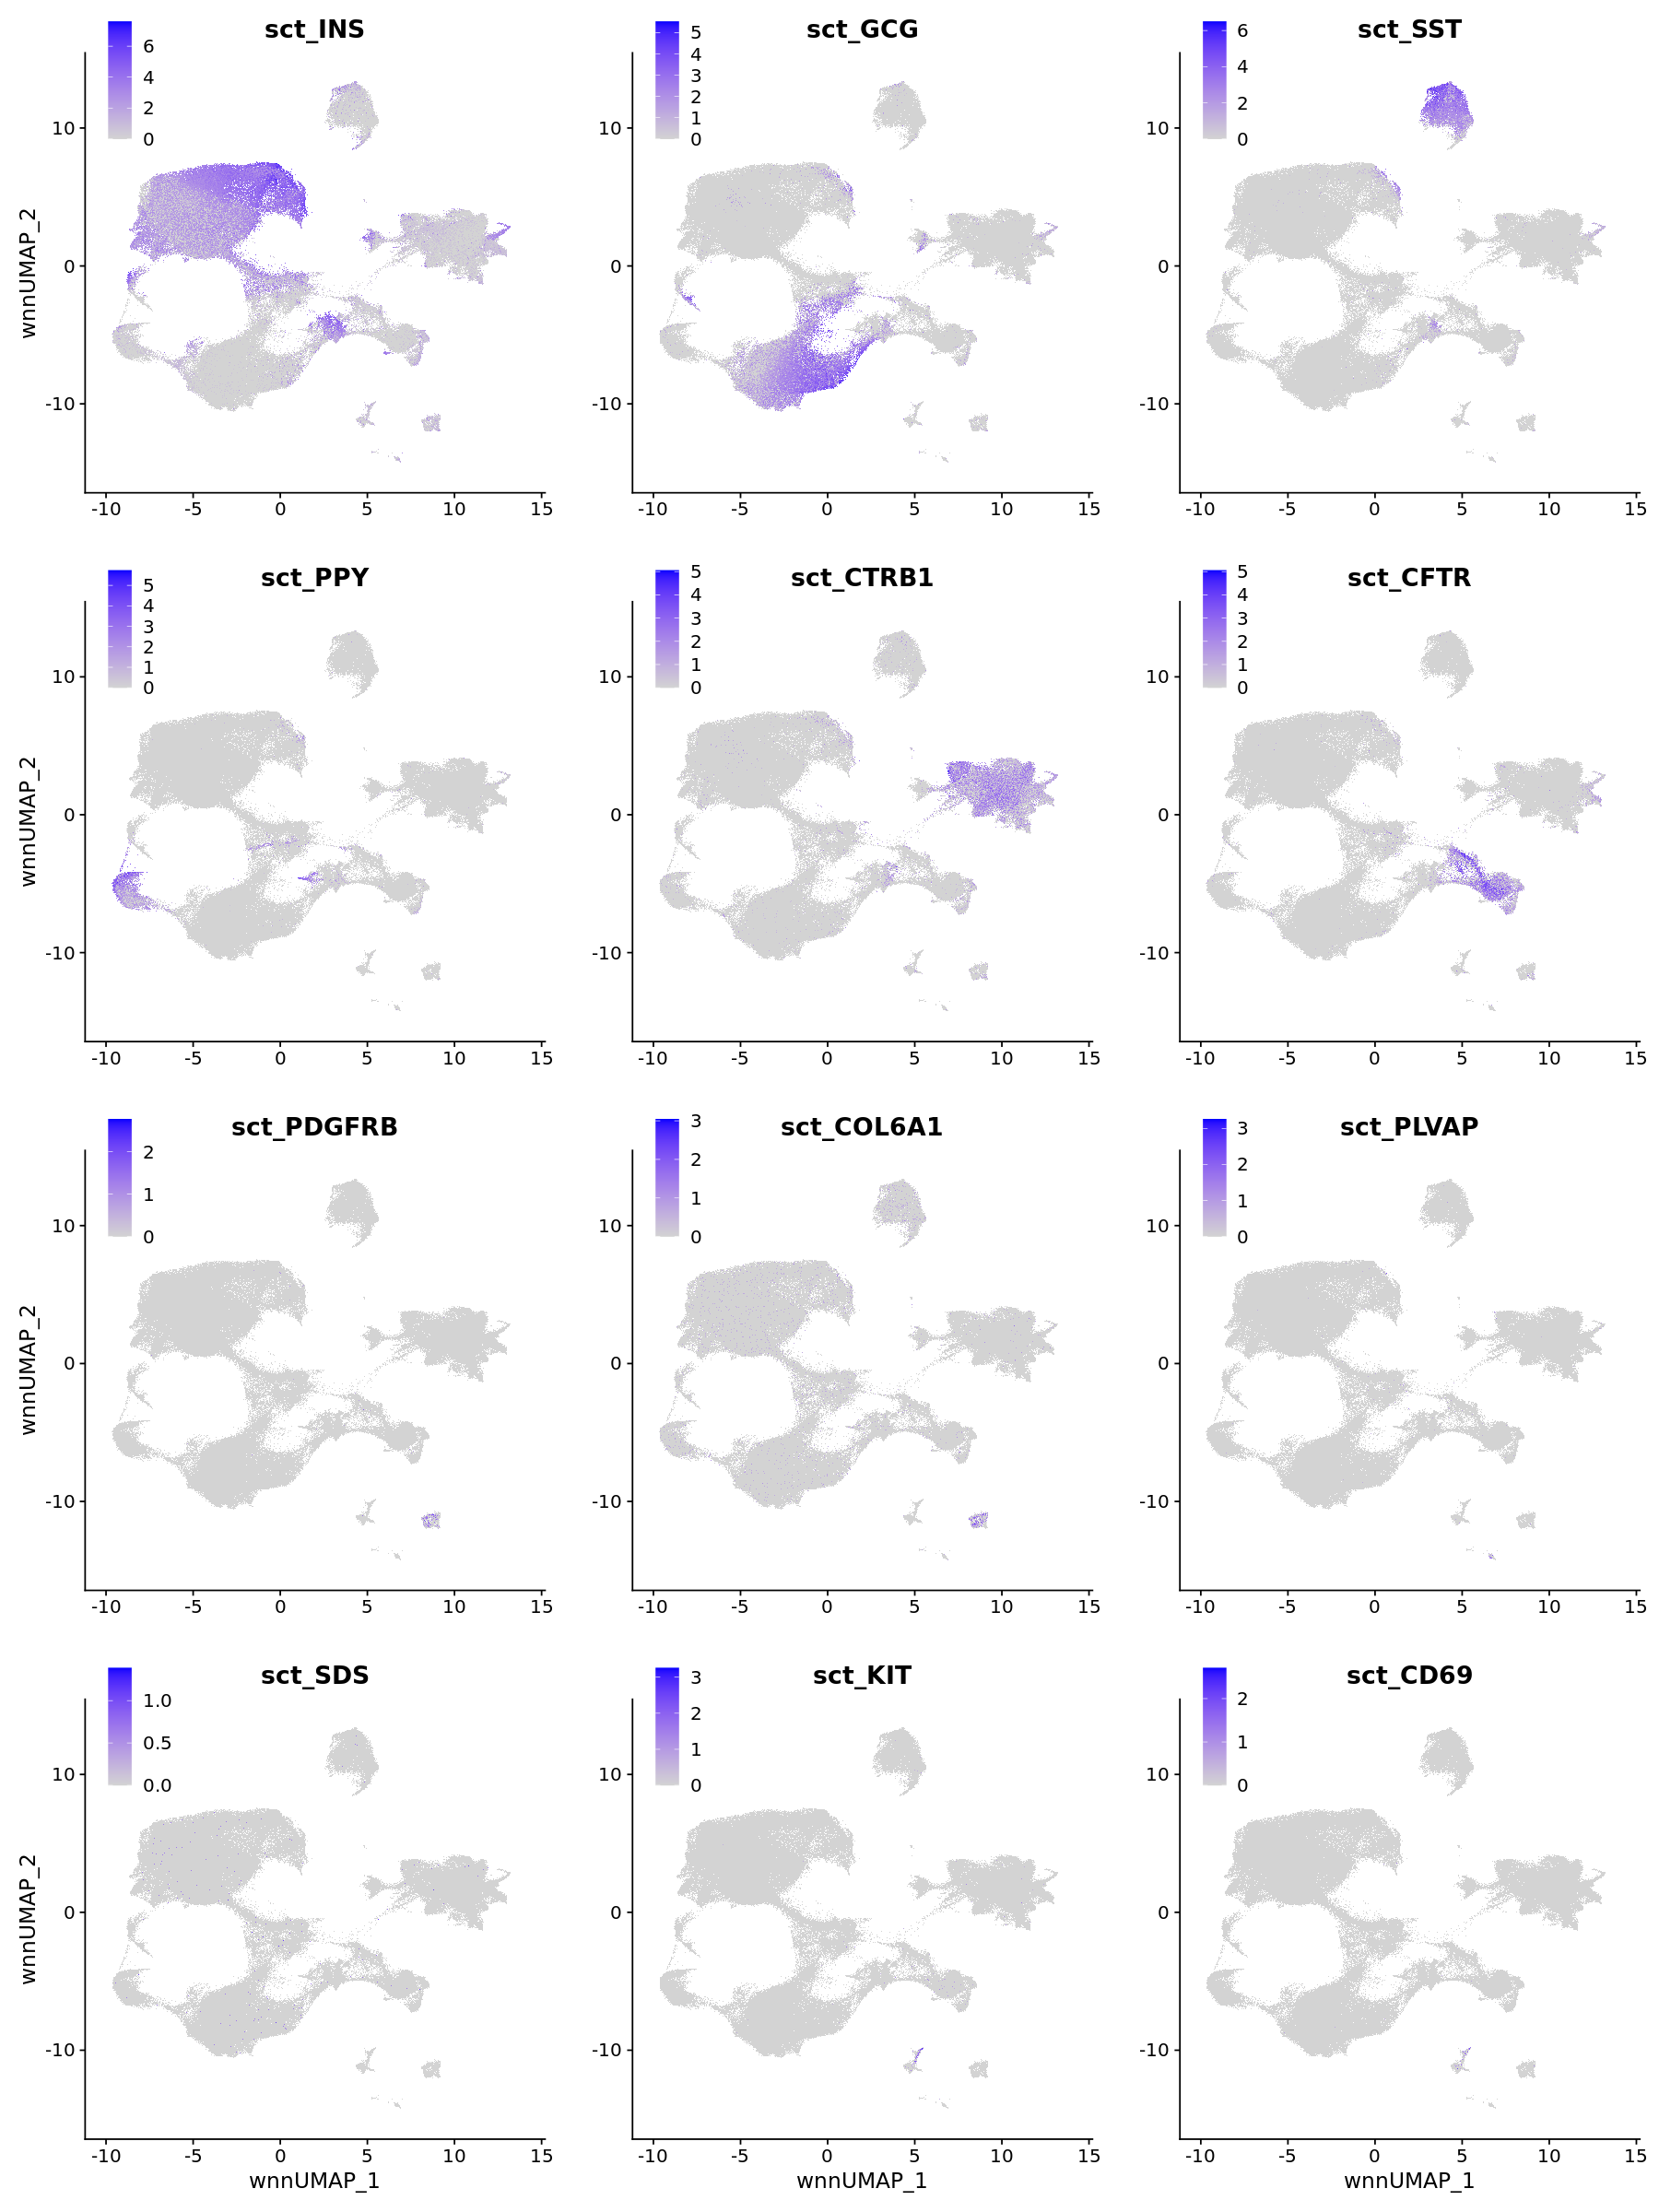

In [121]:
options(repr.plot.width=15, repr.plot.height=20)
p1 <- FeaturePlot(adata2, reduction='umap.wnn', features=c('sct_INS','sct_GCG','sct_SST'), ncol=3)
p2 <- FeaturePlot(adata2, reduction='umap.wnn', features=c('sct_PPY','sct_CTRB1','sct_CFTR'), ncol=3) 
p3 <- FeaturePlot(adata2, reduction='umap.wnn', features=c('sct_PDGFRB','sct_COL6A1','sct_PLVAP'), ncol=3)
# p4 <- FeaturePlot(adata, reduction='umap.wnn', features=c('sct_SDS','sct_KIT','sct_MKI67'), ncol=3)
p4 <- FeaturePlot(adata2, reduction='umap.wnn', features=c('sct_SDS','sct_KIT','sct_CD69'), ncol=3)

for (j in c(1,2,3)) {
    p1[[j]] <- p1[[j]] + xlab('')
    p2[[j]] <- p2[[j]] + xlab('')
    p3[[j]] <- p3[[j]] + xlab('')
}
for (j in c(2,3)) {
    p1[[j]] <- p1[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p2[[j]] <- p2[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p3[[j]] <- p3[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p4[[j]] <- p4[[j]] + ylab('') + theme(legend.position = c(.05, .95))
    p1[[1]] <- p1[[1]] + theme(legend.position = c(.05, .95))
    p2[[1]] <- p2[[1]] + theme(legend.position = c(.05, .95))
    p3[[1]] <- p3[[1]] + theme(legend.position = c(.05, .95))
    p4[[1]] <- p4[[1]] + theme(legend.position = c(.05, .95))
}
p1 / p2 / p3 / p4

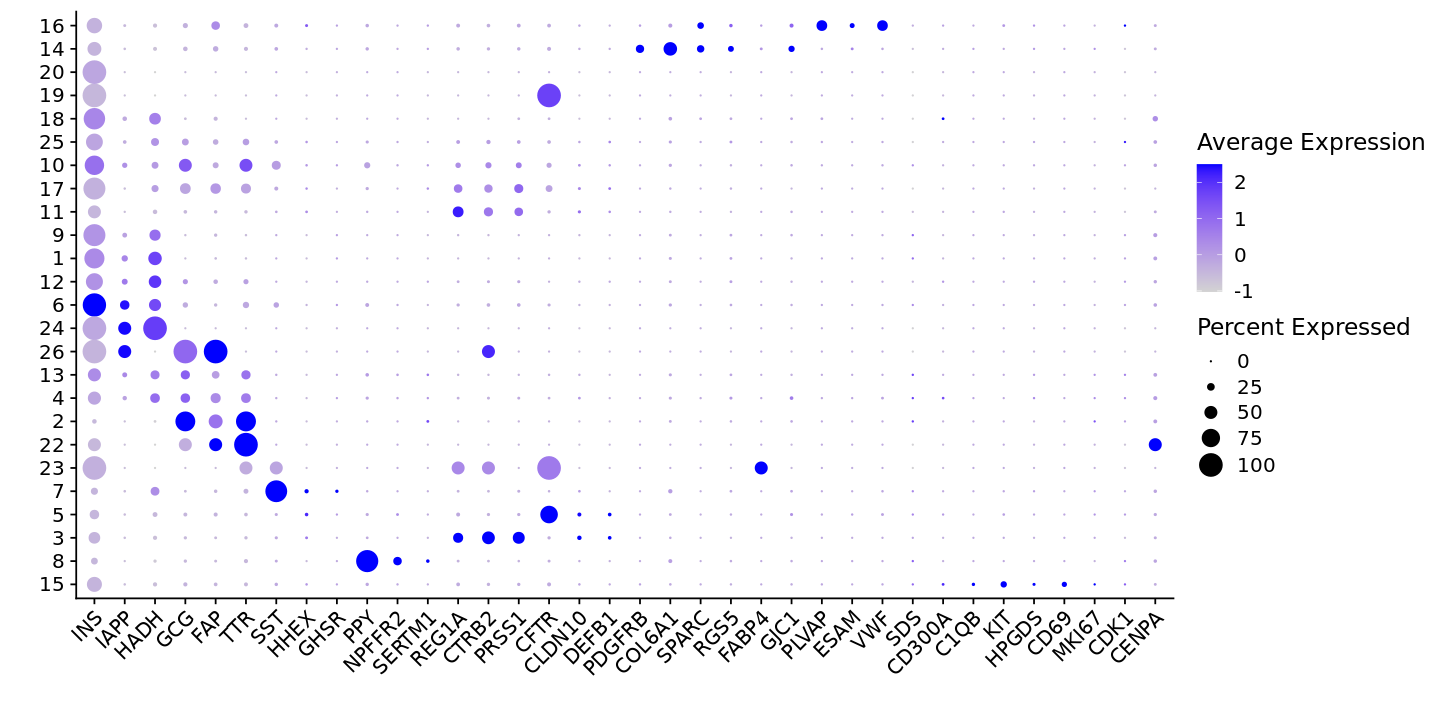

In [122]:
marker.genes <- c('INS','IAPP','HADH',
           'GCG','FAP','TTR',
           'SST','HHEX','GHSR',
           'PPY','NPFFR2','SERTM1',
           'REG1A','CTRB2','PRSS1',
           'CFTR','CLDN10','DEFB1',
           'PDGFRB','COL6A1','SPARC',
           'RGS5','FABP4','GJC1',
           'PLVAP','ESAM','VWF',
           'SDS','CD300A','C1QB',
           'KIT','HPGDS','CD69',
           'MKI67','CDK1','CENPA')
options(repr.plot.width=12, repr.plot.height=6)
p1 <- DotPlot(adata2, assay='SCT', features=marker.genes, cluster.idents=TRUE) 
p1 <- p1 + theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
p1

## Clustering with lower res

In [124]:
# Combining Modalities
adata3 <- adata2
adata3 <- FindMultiModalNeighbors(adata3, reduction.list=list('harmony.rna', 'harmony.atac'), dims.list=list(1:50, 2:50))
adata3 <- RunUMAP(adata3, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
adata3 <- FindClusters(adata3, graph.name='wsnn', algorithm=4,  resolution = 0.5, verbose=FALSE, method = 'igraph')

adata3$log_nCount_ATAC=log(adata3$nCount_ATAC)
adata3$log_nCount_SCT=log(adata3$nCount_SCT)
adata3$log_nFeature_ATAC=log(adata3$nFeature_ATAC)
adata3$log_nFeature_SCT=log(adata3$nFeature_SCT)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

17:14:41 UMAP embedding parameters a = 0.9922 b = 1.112

17:14:45 Commencing smooth kNN distance calibration using 1 thread

17:14:47 1 smooth knn distance failures

17:14:57 Initializing from normalized Laplacian + noise

17:15:37 Commencing optimization for 200 epochs, with 7833542 positive edges

17:18:04 Optimization finished



In [125]:
Sys.time()

[1] "2021-10-15 19:03:32 UTC"

In [126]:
adata3

An object of class Seurat 
119928 features across 233003 samples within 3 assays 
Active assay: ATAC (50000 features, 50000 variable features)
 2 other assays present: RNA, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [127]:
adata3[["ATAC"]]

ChromatinAssay data with 50000 features for 233003 cells
Variable features: 50000 
Genome: hg38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [129]:
length(Cells(adata3))

[1] 233003

Warning message:
"ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


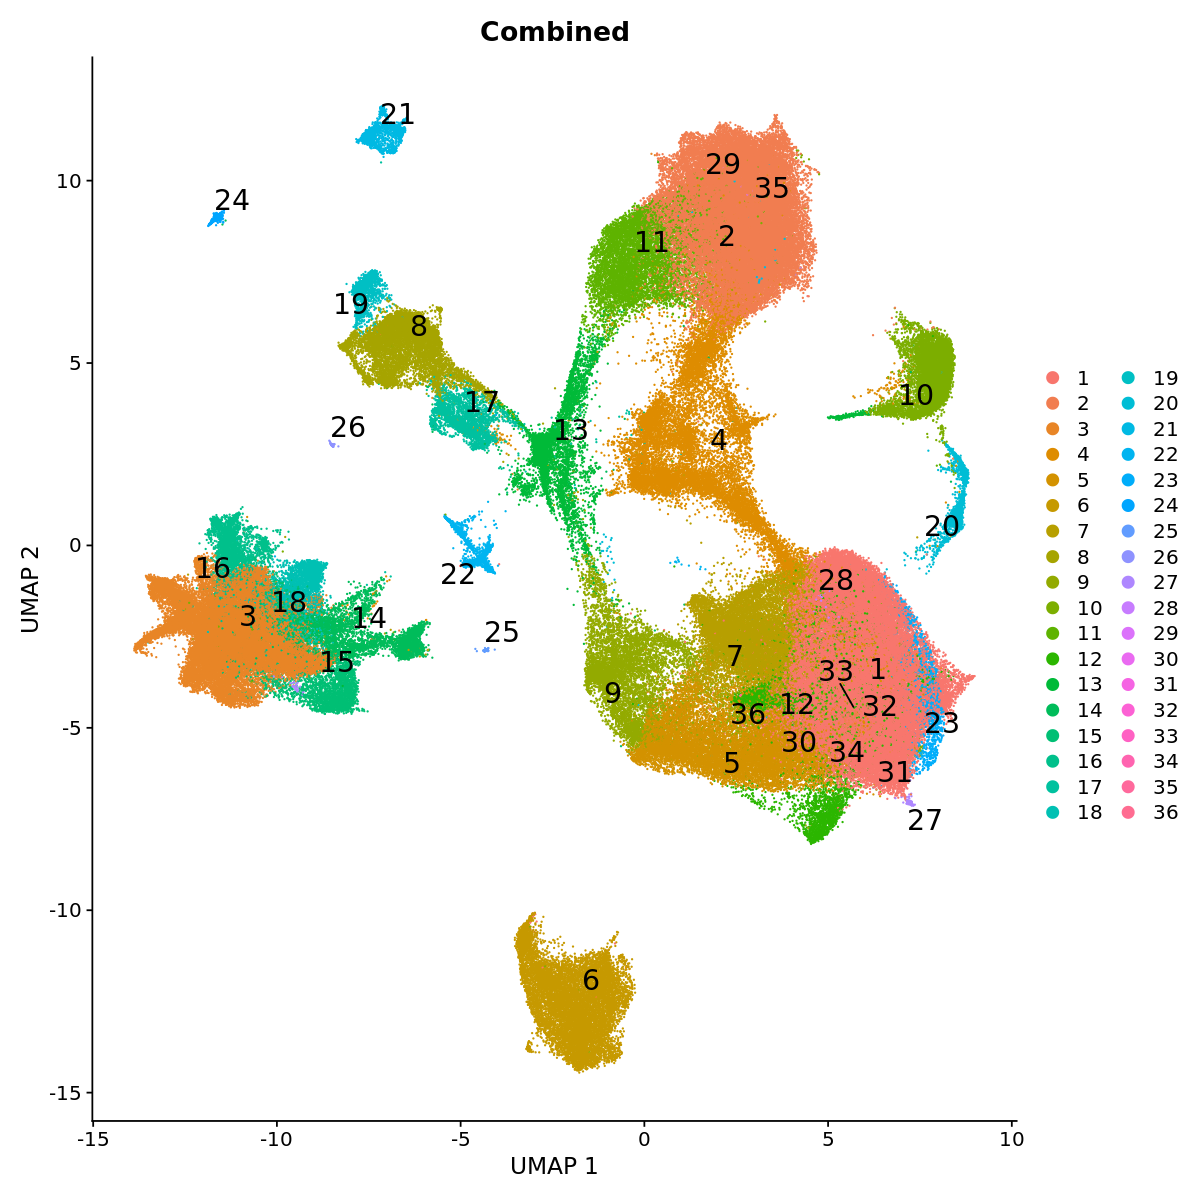

In [128]:
options(repr.plot.width=10, repr.plot.height=10)
p3 <- DimPlot(adata3, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE, raster=FALSE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p3